<a name="TOC"></a>
# Adiabatic (ground and excited states) dynamics with atomistic systems

## Table of Content: <a name="TOC"></a>

1. [Testing the imported atomistic Hamiltonian](#model-setup)
 
 
2. [Adiabatic dynamics on the ground state](#gs-dynamics)

 2.1. [Initialize nuclear variables](#gs-init-nuclei)
 
 2.2. [Initialize electronic variables](#gs-init-elec)
 
 2.3. [Define the dynamical parameters](#gs-dyn-params)
 
 2.4. [Run the calculations](#gs-run)
 
 2.5. [Plot the properties](#gs-properties)
 
 2.6. [Visualize MD trajectories](#gs-md-vis)


3. [Adiabatic dynamics on the excited state](#ex-dynamics)


## A. Learning objectives

- to set up and execute adiabatic MD on ground and excited states with DFTB+/Libra interface


## B. Use cases

- [Adiabatic MD on ground state with DFTB+](#gs-dynamics)
- [Adiabatic MD on excited state with DFTB+](#ex-dynamics)
- [Initialize initial conditions for the atomistic systems](#gs-init-nuclei) | [also here](#gs-init-elec)
- [Visualize the MD trajectories with py3Dmol](#gs-md-vis)


## C. Functions

- `libra_py`
  - `dynamics`
   - `tsh`
    - `compute`      
     - [`generic_recipe`](#generic_recipe-1)
    - `plot`
     - [`hdf2xyz`](#hdf2xyz-ex1) | [also here](#hdf2xyz-ex2) | [also here](#hdf2xyz-ex3)
     - [`plot_dynamics`](#plot_dynamics-1)
  - `data_conv`
   - [`make_list`](#make_list-ex1)
   - [`matrix2list`](#matrix2list-ex1)
  - `data_outs`
   - [`print_matrix`](#print_matrix-ex1)
  - `packages`
   - `dftbplus`
    - `methods`
     - [`run_dftb_adi`](#run_dftb_adi-ex1) | [also here](#run_dftb_adi-ex2)   
   
   
## D. Classes and class members
    
None  



In [25]:
import sys
import cmath
import math
import os
import h5py
#import psi4

import matplotlib.pyplot as plt   # plots
import numpy as np
%matplotlib inline 


if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py.data_visualize import colors, clrs_index
import libra_py.dynamics_plotting as dynamics_plotting
import libra_py.packages.dftbplus.methods as DFTB_methods

import libra_py.data_outs as data_outs
import libra_py.data_conv as data_conv
import libra_py.dynamics.tsh.compute as compute
import libra_py.dynamics.tsh.save as save
import libra_py.dynamics.tsh.plot as plot
import libra_py.dynamics.tsh.recipes as recipes

import py3Dmol   # molecular visualization

<a name="model-setup"></a> [Back to TOC](#TOC)
## 1. Testing the imported atomistic Hamiltonian

Before we run the fully-fledged dynamics, it is wise to check if our driver (the electronic structure package) is actually working. 

In the cell below, we are setting up the geometry for the HFCO molecule and use the `DFTB_methods.run_dftb_adi` method as the compute Hamiltonian function that performs the DFTB+ calculations and extracts the properties we need. More on this is described in [this tutorial](../../../8_model_hamiltonians/2_interfaces_with_qchem_codes/tutorial.ipynb). The DFTB+ wrapper function requires:

* the proper pathes to the excutables (MAKE SURE YOU CHANGE this to adapt to your system)
* atomic labels of the system - need to be changed if you work with another system
* the file `dftb_input_template.hsd` should be located in the directory of this tutorial
* the Slater-Koster files `halorg-0-1` should be located in the directory of this tutorial - make sure you download those from the [official site](https://www.dftb.org/parameters/download/halorg/halorg-0-1-cc/)
* the number of states that will be computed - see the `nstates` parameters. Make sure it doesn't go higher than the value listed in the `dftb_inpute_template.hsf` file in the section:

      ExcitedState {
        Casida {
          NrOfExcitations    = 5
          StateOfInterest    = some_state_index_here
          Symmetry           = singlet
          EnergyWindow [eV]  = 20.0
          ExcitedStateForces = yes
        }
      }

So, lets setup the geometry and input parameters:  <a name="ham-params"></a>

In [2]:
%%time 

ham_params = { "labels":["F", "C", "H", "O"], "nstates":3,
               "dftb_exe":"/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/_install/bin/dftb+",
               "xyz2gen_exe":"xyz2gen",
               "model0":0, "model":0
             }

# This is the input in Angstrom
mol = MATRIX(12,1)
mol.set(0,0, -0.04746);  mol.set(1,0,  0.65920);  mol.set(2,0,  1.04080)
mol.set(3,0, -0.51816);  mol.set(4,0,  0.81540);  mol.set(5,0,  0.06880)
mol.set(6,0,  0.15264);  mol.set(7,0,  1.00050);  mol.set(8,0,  -0.77170)
mol.set(9,0, -1.71206);  mol.set(10,0, 0.78520);  mol.set(11,0, -0.06860)
mol.show_matrix()

# The input is expected to be in Bohr, so lets convert:
mol *= units.Angst

CPU times: user 120 µs, sys: 144 µs, total: 264 µs
Wall time: 206 µs
-0.047460000  
0.65920000  
1.0408000   
-0.51816000  
0.81540000  
0.068800000  
0.15264000  
1.0005000   
-0.77170000  
-1.7120600  
0.78520000  
-0.068600000  



Test your DFTB+ dptools scripts:

In [3]:
!xyz2gen tmp.xyz

ScriptError: You must enter a valid path to the input file.


And run the calculations
<a name="run_dftb_adi-ex1"></a>

In [4]:
id = Py2Cpp_int([0, 0])
obj_dftb = DFTB_methods.run_dftb_adi(mol, ham_params, id )

|===============================================================================
|
|  DFTB+ development version (commit: 3f79963e, base: 22.2)
|
|  Copyright (C) 2006 - 2022  DFTB+ developers group
|
|===============================================================================
|
|  When publishing results obtained with DFTB+, please cite the following
|  reference:
|
|  * DFTB+, a software package for efficient approximate density functional
|    theory based atomistic simulations, J. Chem. Phys. 152, 124101 (2020).
|    [doi: 10.1063/1.5143190]
|
|  You should also cite additional publications crediting the parametrization
|  data you use. Please consult the documentation of the SK-files for the
|  references.
|
|===============================================================================

Reading input file 'dftb_in.hsd'
Parser version: 13

--------------------------------------------------------------------------------
***  Converting input from parser version  4 to parser ver

    5   -0.99462002E+01    0.45987619E-03    0.13866250E-01
    6   -0.99480382E+01   -0.18379517E-02    0.15721249E-01
    7   -0.99480348E+01    0.34346499E-05    0.19763389E-02
    8   -0.99480487E+01   -0.13972325E-04    0.62691212E-04
    9   -0.99480489E+01   -0.21159735E-06    0.33934110E-07
   10   -0.99480489E+01   -0.21248425E-09    0.24026026E-09
>> Charges saved for restart in charges.bin

Total Energy:                       -9.4163884372 H         -256.2330 eV
Extrapolated to 0K:                 -9.6623681793 H         -262.9264 eV
Total Mermin free energy:           -9.4163884372 H         -256.2330 eV
Force related energy:               -9.6623681793 H         -262.9264 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
Pre-SCC initialisation                 +       0.02 (  0.2%

If this step competes successfully, you should be good to go to the dynamics.

<a name="gs-dynamics"></a> [Back to TOC](#TOC)
## 2. Adiabatic dynamics on the ground state

In this section, we are going to setup and run the adiabatic dynamics of the HFCO molecule using DFTB+ package as the electronic structre calculations drivier. In this section, we will be using an expanded version of syntax - such that it is very verbose and descriptive. In the [next section](#ex-dynamics), we are going to setup and run the excited state calculations and will use the shortened notations (for brevity) and some auxiliary functions that aim to make these calculations as simple and straightforward as possible.

Our computational setup will contain the following steps:

1. [Initialize nuclear variables](#gs-init-nuclei)
2. [Initialize electronic variables](#gs-init-elec)
3. [Define the dynamical parameters](#gs-dyn-params)
4. [Run the calculations](#gs-run)
5. [Plot the properties](#gs-properties)
6. [Visualize MD trajectories](#gs-md-vis)

<a name="gs-init-nuclei"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.1. Initialize nuclear variables 

In this section, we initialize the coordinates and momenta of all nuclei.

**IMPORTANT VARIABLES:** 
* `ntraj` - how many trajectories we want to run. This number will be used in the following cells too, in the electronic variables initialization.

Other parameters of interest:

* `k0` - is a list of force constants for each DOFs. These force constants define the harmonic oscillator (HO) ground state (Gaussian) wavefunction widths in the coordinate and momentum spaces. The larger the value of the force constant, the smaller the width in the coordiante space. This width determined how much the reference coordinates and momenta (`q0` and `p0`, respectively) will be displaced randomly. <a name="make_list-ex1"></a>
  This parameter is a list - we initially make use of the convenience function `data_conv.make_list`, to assign  the same width to all the DOFs, but one can adjust it after. 
<a name="matrix2list-ex1"></a> 
* `q0` and `p0` - are the reference coordinates and momenta. Note the use of the convenience functions `data_conv.matrix2list` and `data_conv.make_list` to generate them.

* `masses` - should be of the `ndof` length, that is `3 * natoms`. Each triple of the masses ilists the same values since those correspond to x, y, and z components of the same atom. For convenience, we set them up in terms of chemical weights, but since all the calculations are done in atomic units, we do convert the mases using the `units.amu` constant. 

* `q`, `p` - are the actual coordiantes and momenta of all trajectories to be propagated. Those are generated using the function `compute.init_nuclear_dyn_var`. The `init_type = 3` in the parameters passed to this function asks to generate these "actual" coordinates by sampling from the Wigner distributions for each of the DOFs. Each of the resulting matrices is of shape `ndof x ntraj`

* finally, note the use of the `data_outs.print_matrix` function to print out the generated coordinates and momenta. <a name="print_matrix-ex1"></a>
<a name="init-nucl-ex1"></a>

In [5]:
# Random numbers generator object
rnd = Random()

ndia = nadi = 3
ndof = mol.num_of_rows
ntraj = 2


q0 = data_conv.matrix2list(mol)
p0 = data_conv.make_list(ndof, 0.0)
masses = [ 19.0, 19.0, 19.0,
           12.0, 12.0, 12.0,
            1.0,  1.0,  1.0,
           16.0, 16.0, 16.0
         ]
for index, item in enumerate(masses):
    masses[index] *= units.amu
k0 = data_conv.make_list(ndof, 0.1)  # force constants for initialization
        
# Initialize nuclear variables
#icond_nucl = 0  # Coords and momenta are set exactly to the given value
#icond_nucl = 1  # Coords are set, momenta are sampled
#icond_nucl = 2  # Coords are sampled, momenta are set
icond_nucl = 3  # Both coords and momenta are samples

nucl_params = {"init_type":icond_nucl,  "ndof": ndof, 
             "q":q0, "p":p0, "mass":masses,   "force_constant":k0 
            }

# Sample nuclear DOFs    
dyn_var = dyn_variables(ndia, nadi, ndof, ntraj)
dyn_var.init_nuclear_dyn_var(nucl_params, rnd)


print("nuclear coordinates of all trajectories[a.u.]:")
data_outs.print_matrix(dyn_var.get_coords())

print("nuclear momenta of all trajectories [a.u.]:")
data_outs.print_matrix(dyn_var.get_momenta())

print("inverse masses:")
data_outs.print_matrix(dyn_var.get_imass())

nuclear coordinates of all trajectories[a.u.]:
0.015605810118149488  -0.01051236117229351  
1.1172297220558844  1.2403549892030437  
1.9096504130008336  1.956262176238525  
-1.0668815893187418  -0.7139379105228358  
1.4395788786877233  1.716482675022652  
0.08133811509846026  0.05355788397712265  
0.1477705635317373  0.449943316365172  
1.9863275537747096  1.7861023388311115  
-1.488618595211791  -1.2613091740827738  
-3.1379137610443593  -3.1732426384987185  
1.3625468494229471  1.6225155643505729  
-0.11444446495667154  -0.1330343363541465  
nuclear momenta of all trajectories [a.u.]:
-6.22767474825302  -8.591358080746774  
-11.079000523595832  2.662705148080204  
6.341708308093902  0.29639416625110343  
0.9689720129783798  -0.9799755574785334  
5.016056948788089  2.9168027242318804  
-1.2888240202944532  -4.340538353018394  
4.212881300594646  5.247147242557015  
1.5038198621002998  -2.391696261287546  
0.640732075891865  1.0823846978335114  
3.1261299520394985  -6.692701097745079  

<a name="gs-init-elec"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.2. Initialize electronic variables 

In this section, we initialize the coordinates of all electronic variables - the amplituded of the adiabatic states

**IMPORTANT VARIABLES:** 

* `init_elec["nstates"] = 3` - the number of electronic states to represent vibronic Hamiltonian. Make sure, this number is consisten with `ham_params["nstates"]`

* `init_elec["istates"]` - together with the option `init_elec["init_type"] = 3` specifies the starting populations of all states. This should be a list of floats (summing up to 1.0) of the length equal to `init_elec["nstates"]` (3 in this case). MAKE SURE YOU SET THIS CONSISTENTLY with the expected type of calculations (on the correct PES) - this is what will actually select on which PES the dynamics occurs. 


Other variables of interest:
* the generation of all electronic "working" variables, which are used as the input to the dynamical calculations functions is done with the help of `compute.init_electronic_dyn_var` function. In the present setup (e.g. with `init_type = 3`), the amplitudes for the electronic states are randomized in phases, but to preserve the populations given in the `istates` parameter. 
<a name="init-elec-ex1"></a>

In [6]:
#============= How electronic DOFs are initialized ==================
#icond_elec = 0  # amplitudes all have the same phase, using `istate`
#icond_elec = 1  # amplitudes gain random phase, using `istate`
#icond_elec = 2  # amplitudes all have the same phase, using `istates`
icond_elec = 3  # amplitudes gain random phase, using `istates`

#============= Also select the representation ========================
# rep = 0 # diabatic wfc
rep = 1 # adiabatic wfc

# Initialize electronic variables
elec_params = { "verbosity":2, "init_dm_type":0,
              "ndia":3, "nadi":3, "istates":[1.0, 0.0, 0.0],
              "rep":rep, "init_type":icond_elec
            }

dyn_var.init_amplitudes(elec_params, rnd)
dyn_var.init_density_matrix(elec_params)
dyn_var.init_active_states(elec_params, rnd)

print("electronic amplitudes (adiabatic) of the first trajectory")
data_outs.print_matrix(dyn_var.get_ampl_adi())

print("initial states for surface hopping = ", Cpp2Py(dyn_var.act_states) )

electronic amplitudes (adiabatic) of the first trajectory
(0.090465217887634-0.9958996156001583j)  (0.01805466332360812+0.9998370012818445j)  
(-0+0j)  (-0+0j)  
-0j  (-0-0j)  
initial states for surface hopping =  [0, 0]
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
========== ampl_dia ===============
(0.0000000,0.0000000)  (0.0000000,0.0000000)  
(0.0000000,0.0000000)  (0.0000000,0.0000000)  
(0.0000000,0.0000000)  (0.0000000,0.0000000)  

========== ampl_adi ===============
(0.090465218,-0.99589962)  (0.018054663,0.99983700)  
(-0.0000000,0.0000000)  (-0.0000000,0.0000000)  
(0.0000000,-0.0000000)  (-0.0000000,-0.0000000)  



<a name="gs-dyn-params"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.3. Define the dynamical parameters

The code below is pretty self-explanatory. Essentially, we go through (almost) all the potential input parameters and set them up in such a way that:

* the adiabatic dynamics is requested;

* only a minimal necessary set of Hamiltonian properties (energies and gradients) can be successfully used - since this is pretty much all we get from the DFTB+ calculations with the `DFTB_methods.run_dftb_adi` function;

* no surface hopping, no decoherence, no phase corrections, no state tracking, no trajectory entanglements are request, so many of the otherwise require parameters not needed or are not relevant;

* we setup parameters to generate the output files that contain enough information for the useful printing and visualization.

Don't worry - to simplify our life in future, we have defined a `libra_py.dynamics.tsh.recipes` module that implements several functions to return the parameters for various types of calculations such as this. In fact, the setups defined below are consistent with the parameters returned by the `adiabatic_md_interfaces_params` function - we will use this function in [section 3](#ex-dynamics)


**IMPORTANT VARIABLES:**

* `dyn_params["nsteps"]` - you can change that to control the length of the MD simulation to run


In [14]:
dyn_general = { "nsteps":10, "ntraj":2, "nstates":3,
                "dt":10.0, "num_electronic_substeps":1, "isNBRA":0, "is_nbra":0,
                "progress_frequency":0.1, "which_adi_states":range(3), "which_dia_states":range(3),      
                "mem_output_level":4,
                "properties_to_save":[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
                "se_pop_adi", "se_pop_dia", "sh_pop_adi", "hvib_adi", "hvib_dia", "St", "basis_transform", "D_adi"],
                "prefix":"adiabatic_md", "prefix2":"adiabatic_md"
              }

In [15]:
# Uncomment one of the options in each of the categories below:
#====== How to update Hamiltonian ===================
#dyn_general.update({"ham_update_method":0}) # don't update any Hamiltonians
#dyn_general.update({"ham_update_method":1})  # recompute only diabatic Hamiltonian, common choice for model Hamiltonians 
dyn_general.update({"ham_update_method":2})  # recompute only adiabatic Hamiltonian; use with file-based or on-the-fly workflows


#====== How to transform the Hamiltonians between representations ============
dyn_general.update( {"ham_transform_method":0 }) # don't do any transforms; usually for NBRA or on-the-fly workflows, 
                                                 # so you don't override the read values
#dyn_general.update( {"ham_transform_method":1 }) # diabatic->adiabatic according to internal diagonalization
#dyn_general.update( {"ham_transform_method":2 }) # diabatic->adiabatic according to internally stored basis transformation matrix
#dyn_general.update( {"ham_transform_method":3 }) # adiabatic->diabatic according to internally stored basis transformation matrix
#dyn_general.update( {"ham_transform_method":4 }) # adiabatic->diabatic according to local diabatization method

#====== How do get the time-overlaps in the dynamics ========
dyn_general.update( {"time_overlap_method":0 })  # don't update time-overlaps - maybe they are already pre-computed and read
#dyn_general.update( {"time_overlap_method":1 }) # explicitly compute it from the wavefunction info; common for model Hamiltonians

#================== How to compute NACs ===============================
#dyn_general.update({"nac_update_method":1})  # explicit NAC calculations - let's just focus on this one for now
dyn_general.update({"nac_update_method":2, "nac_algo":0})  # HST algo - using time-overlaps
#dyn_general.update({"nac_update_method":2, "nac_algo":1})  # NPI algo

#============== How to compute vibronic Hamiltonian ==============
dyn_general.update( {"hvib_update_method":0 }) # don't update Hvib; maybe because we read it from files
#dyn_general.update( {"hvib_update_method":1 }) # recompute diabatic and adiabatic Hvib from the Ham and NACs in those reps

#=========== Ehrenfest or state-resolved options ===========
# This is what we use with any of the TSH-based methods - in all cases here, we would 
# use "rep_force":1 so that we are guided by the forces derived from the adiabatic surfaces.
# In Ehrenfest cases though, the forces can be computed using only diabatic properties though 
dyn_general.update( {"force_method":1, "rep_force":1} ) # state-resolved (e.g. TSH) with adiabatic forces
#dyn_general.update( {"force_method":2, "rep_force":1} ) # for Ehrenfest in adiabatic rep
#dyn_general.update( {"force_method":2, "rep_force":0} ) # for Ehrenfest in diabatic rep


#============ Types of surface hopping acceptance and momenta rescaling opntions =================
#dyn_general.update({"hop_acceptance_algo":10, "momenta_rescaling_algo":100 })  # accept and rescale based on total energy, do not reverse on frustrated
dyn_general.update({"hop_acceptance_algo":10, "momenta_rescaling_algo":101 })  # accept and rescale based on total energy, reverse on frustrated
#dyn_general.update({"hop_acceptance_algo":20, "momenta_rescaling_algo":200 })  # accept and rescale based on NAC vectors, do not reverse on frustrated
#dyn_general.update({"hop_acceptance_algo":20, "momenta_rescaling_algo":201 })  # accept and rescale based on NAC vectors, reverse on frustrated
#dyn_general.update({"hop_acceptance_algo":21, "momenta_rescaling_algo":200 })  # accept and rescale based on force differences, do not reverse on frustrated
#dyn_general.update({"hop_acceptance_algo":21, "momenta_rescaling_algo":201 })  # accept and rescale based on force differences, reverse on frustrated


#============ Surface hopping opntions =================
dyn_general.update({"tsh_method":-1 }) # adiabatic, no surface hopping
#dyn_general.update({"tsh_method":0 }) # FSSH
#dyn_general.update({"tsh_method":1 }) # GFSH
#dyn_general.update({"tsh_method":2 }) # MSSH
#dyn_general.update({"tsh_method":3, "rep_lz":0 })  # LZ options
#dyn_general.update({"tsh_method":4, "rep_lz":0 }) # ZN
#dyn_general.update({"tsh_method":5 }) # DISH

#=========== Decoherence options =================
dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence
#dyn_general.update({ "decoherence_algo":0}) # msdm  
#dyn_general.update({ "decoherence_algo":1}) # IDA
#dyn_general.update({ "decoherence_algo":2}) # A-FSSH, not yet ready
#dyn_general.update({ "decoherence_algo":3}) # BCSH
#dyn_general.update({ "decoherence_algo":4}) # mfsd

#=========== Decoherence times (for decoherence options 0 or 4) ==================
A = MATRIX(2,2); A.set(0, 0, 10.0); A.set(1,1, 10.0)
dyn_general.update({"decoherence_times_type":-1 }) # No decoherence times, infinite decoherence times
#dyn_general.update( { "decoherence_times_type":1, "decoherence_C_param": 1.0, "decoherence_eps_param":0.1 } )  # EDC + default params
#dyn_general.update( { "decoherence_times_type":2, "schwartz_decoherence_inv_alpha":A } ) # Schwartz version 1
#dyn_general.update( { "decoherence_times_type":3, "schwartz_decoherence_inv_alpha":A } ) # Schwartz version 2

#======= Various decoherence-related parameters =====================
dyn_general.update( {"dephasing_informed":0, "decoherence_rates":MATRIX(2,2), "ave_gaps":MATRIX(2,2) } )
                               
#=========== Phase correction of SSY =================
dyn_general.update({"do_ssy":0 }) # do no use it - that's the default

#=========== What to integrate ==================
# solve TD-SE in diabatic representation
#dyn_general.update({"rep_tdse":0, "electronic_integrator":-1 })   # no propagation
#dyn_general.update({"rep_tdse":0, "electronic_integrator":0 })    # Lowdin exp_ with 2-point Hvib_dia
#dyn_general.update({"rep_tdse":0, "electronic_integrator":1 })    # based on QTAG propagator
#dyn_general.update({"rep_tdse":0, "electronic_integrator":2 })    # based on modified QTAG propagator (Z at two times)
#dyn_general.update({"rep_tdse":0, "electronic_integrator":3 })    # non-Hermitian integrator with 2-point Hvib_dia

# solve TD-SE in adiabatic representation
#dyn_general.update({"rep_tdse":1, "electronic_integrator":-1 })  # no propagation
#dyn_general.update({"rep_tdse":1, "electronic_integrator":0 })   # ld, with crude splitting,  with exp_
#dyn_general.update({"rep_tdse":1, "electronic_integrator":1 })   # ld, with symmetric splitting, with exp_
dyn_general.update({"rep_tdse":1, "electronic_integrator":2 })   # ld, original, with exp_
#dyn_general.update({"rep_tdse":1, "electronic_integrator":3 })   # 1-point, Hvib integration, with exp_
#dyn_general.update({"rep_tdse":1, "electronic_integrator":4 })   # 2-points, Hvib integration, with exp_
#dyn_general.update({"rep_tdse":1, "electronic_integrator":5 })   # 2-points, Hvib, integration with the second-point correction of Hvib, with exp_
#dyn_general.update({"rep_tdse":1, "electronic_integrator":6 })   # same as 4, but without projection matrices (T_new = I)
#dyn_general.update({"rep_tdse":1, "electronic_integrator":10 })  # same as 0, but with rotations
#dyn_general.update({"rep_tdse":1, "electronic_integrator":11 })  # same as 1, but with rotations
#dyn_general.update({"rep_tdse":1, "electronic_integrator":12 })  # same as 2, but with rotations
#dyn_general.update({"rep_tdse":1, "electronic_integrator":13 })  # same as 3, but with rotations
#dyn_general.update({"rep_tdse":1, "electronic_integrator":14 })  # same as 4, but with rotations
#dyn_general.update({"rep_tdse":1, "electronic_integrator":15 })  # same as 5, but with rotations

# solve QCLE in diabatic representation
#dyn_general.update({"rep_tdse":3, "electronic_integrator":0 })  # mid-point Hvib, using exp_

# solve QCLE in adiabatic representation
#dyn_general.update({"rep_tdse":3, "electronic_integrator":0 })  # mid-point Ham with the second-point correction of Hvib, using exp_
#dyn_general.update({"rep_tdse":3, "electronic_integrator":1 })  # using Zhu Liouvillian THIS IS NOT JUST A DIFFERENT INTEGRATOR!!!!
#dyn_general.update({"rep_tdse":3, "electronic_integrator":10 }) # same as 0 but with rotations


<a name="gs-run"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.4. Run the calculations

Finally, it is time to run the calculations. 

It takes all the parameters and input dynamical variables defined above.

In addition, one needs to specify the function that does the Hamiltonian properties calculations and the corresponding parameters. In this case, we use one of the pre-defined functions, `DFTB_methods.run_dftb_adi` and the parameters [defined above](#ham-params).

More on how to define such Hamiltonian computation functions, is discussed in [this tutorial](../../../8_model_hamiltonians/2_interfaces_with_qchem_codes/tutorial.ipynb)<a name="run_dftb_adi-ex2"></a>

In [9]:
help(DFTB_methods.run_dftb_adi)

Help on function run_dftb_adi in module libra_py.packages.dftbplus.methods:

run_dftb_adi(q, params_, full_id)
    This function executes the DFTB+ quantum chemistry calculations and 
    returns the key properties needed for dynamical calculations.
    
    Args: 
        q ( MATRIX(ndof, ntraj) ): coordinates of the particle [ units: Bohr ]
        params ( dictionary ): model parameters
    
            * **params["labels"]** ( list of strings ): the labels of atomic symbolc - for all atoms,
                and in a order that is consistent with the coordinates (in triples) stored in `q`.
                The number of this labels is `natoms`, such that `ndof` = 3 * `natoms`. [ Required ]                
            * **params["nstates"]** ( int ): the total number of electronic states 
                in this model [ default: 1 - just the ground state]                     
            * **params["dftb_input_template_filename"]** ( string ):  the name of the input file template
     

<a name="generic_recipe-1"></a>

In [16]:
%%time

dyn_params = dict(dyn_general)

rnd = Random()
res = compute.generic_recipe(dyn_params, DFTB_methods.run_dftb_adi, ham_params, elec_params, nucl_params, rnd)

defined! in the input parametersUse the default value 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
========== ampl_dia ===============
(0.0000000,0.0000000)  (0.0000000,0.0000000)  
(0.0000000,0.0000000)  (0.0000000,0.0000000)  
(0.0000000,0.0000000)  (0.0000000,0.0000000)  

========== ampl_adi ===============
(-0.98651046,0.16369825)  (-0.31943266,0.94760898)  
(0.0000000,-0.0000000)  (0.0000000,0.0000000)  
(-0.0000000,-0.0000000)  (-0.0000000,-0.0000000)  

|===============================================================================
|
|  DFTB+ development version (commit: 3f79963e, base: 22.2)
|
|  Copyright (C) 2006 - 2022  DFTB+ developers group
|
|=====================================================================

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-C.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514947225
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
  

>> Charges saved for restart in charges.bin

Total Energy:                       -9.3806543485 H         -255.2606 eV
Extrapolated to 0K:                 -9.7139203845 H         -264.3292 eV
Total Mermin free energy:           -9.3806543485 H         -255.2606 eV
Force related energy:               -9.7139203845 H         -264.3292 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       3.76 ( 59.0%)       0.24 ( 58.5%)
Post-SCC processing                    +       2.60 ( 40.8%)       0.17 ( 40.0%)
--------------------------------------------------------------------------------
Missing                                +       0.01 (  0.1%)       0.01 (  1.5%)
Total                                  =       6.37 (100.0%)       0.41 (100.0%)
--------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514949629
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self


Total Energy:                       -9.2214636734 H         -250.9288 eV
Extrapolated to 0K:                 -9.6349123324 H         -262.1793 eV
Total Mermin free energy:           -9.2214636734 H         -250.9288 eV
Force related energy:               -9.6349123324 H         -262.1793 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.34 ( 69.0%)       0.41 ( 68.6%)
Post-SCC processing                    +       2.80 ( 30.4%)       0.18 ( 29.9%)
Post-geometry optimisation             +       0.05 (  0.6%)       0.00 (  0.2%)
--------------------------------------------------------------------------------
Missing                                +       0.00 (  0.0%)       0.01 (  1.4%)
Total                                  =       9.19 (100.0

    1    0.00000000E+00    0.00000000E+00    0.98765552E+00
    2   -0.99297202E+01   -0.99297202E+01    0.72071086E+00
    3   -0.99425408E+01   -0.12820624E-01    0.81992618E-01
    4   -0.99532416E+01   -0.10700832E-01    0.12388481E+00
    5   -0.99532521E+01   -0.10422660E-04    0.13635149E-01
    6   -0.99539671E+01   -0.71501292E-03    0.10184691E-01
    7   -0.99539711E+01   -0.40605129E-05    0.11993974E-03
    8   -0.99539771E+01   -0.59758586E-05    0.13606806E-06
    9   -0.99539771E+01   -0.84741636E-09    0.26933744E-09
>> Charges saved for restart in charges.bin

Total Energy:                       -9.7127298821 H         -264.2968 eV
Extrapolated to 0K:                 -9.7127298821 H         -264.2968 eV
Total Mermin free energy:           -9.7127298821 H         -264.2968 eV
Force related energy:               -9.7127298821 H         -264.2968 eV


--------------------------------------------------------------------------------
DFTB+ running times                     

    1    0.00000000E+00    0.00000000E+00    0.98765552E+00
    2   -0.99297202E+01   -0.99297202E+01    0.72071086E+00
    3   -0.99425408E+01   -0.12820624E-01    0.81992618E-01
    4   -0.99532416E+01   -0.10700832E-01    0.12388481E+00
    5   -0.99532521E+01   -0.10422660E-04    0.13635149E-01
    6   -0.99539671E+01   -0.71501292E-03    0.10184691E-01
    7   -0.99539711E+01   -0.40605129E-05    0.11993974E-03
    8   -0.99539771E+01   -0.59758586E-05    0.13606806E-06
    9   -0.99539771E+01   -0.84741636E-09    0.26933744E-09
>> Charges saved for restart in charges.bin

Total Energy:                       -9.3785348161 H         -255.2029 eV
Extrapolated to 0K:                 -9.7127298821 H         -264.2968 eV
Total Mermin free energy:           -9.3785348161 H         -255.2029 eV
Force related energy:               -9.7127298821 H         -264.2968 eV


--------------------------------------------------------------------------------
DFTB+ running times                     

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514954923
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self

    8   -0.10038628E+02   -0.27835810E-06    0.28946493E-07
    9   -0.10038628E+02   -0.65458750E-11    0.31573855E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.2204477433 H         -250.9011 eV
Extrapolated to 0K:                 -9.6340102586 H         -262.1548 eV
Total Mermin free energy:           -9.2204477433 H         -250.9011 eV
Force related energy:               -9.6340102586 H         -262.1548 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.81 ( 69.5%)       0.45 ( 69.5%)
Post-SCC processing                    +       2.98 ( 30.5%)       0.19 ( 29.1%)
--------------------------------------------------------------------------------
Missing                                +       0.01 (  0

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514957696
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit b

    5   -0.99546133E+01   -0.32017428E-04    0.13390884E-01
    6   -0.99552983E+01   -0.68503102E-03    0.99270110E-02
    7   -0.99553023E+01   -0.40095969E-05    0.11513687E-03
    8   -0.99553080E+01   -0.56741111E-05    0.15167494E-06
    9   -0.99553080E+01   -0.78199491E-09    0.68138473E-09
>> Charges saved for restart in charges.bin

Total Energy:                       -9.3773514025 H         -255.1707 eV
Extrapolated to 0K:                 -9.7122808512 H         -264.2846 eV
Total Mermin free energy:           -9.3773514025 H         -255.1707 eV
Force related energy:               -9.7122808512 H         -264.2846 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.94 ( 71.0%)       0.44 ( 70.0%)
Post-SCC processing                   

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-C.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514960065
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
  

    5   -0.10037966E+02   -0.39199385E-03    0.27845824E-02
    6   -0.10038044E+02   -0.78096388E-04    0.24632765E-02
    7   -0.10038044E+02   -0.11774120E-06    0.11485675E-04
    8   -0.10038044E+02   -0.28566463E-06    0.28833355E-07
    9   -0.10038044E+02   -0.66595618E-11    0.29821479E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.2223989888 H         -250.9542 eV
Extrapolated to 0K:                 -9.6349843756 H         -262.1813 eV
Total Mermin free energy:           -9.2223989888 H         -250.9542 eV
Force related energy:               -9.6349843756 H         -262.1813 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.20 ( 68.8%)       0.40 ( 68.2%)
Post-SCC processing                   

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-C.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514962832
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
  


Total Energy:                       -9.3771613832 H         -255.1655 eV
Extrapolated to 0K:                 -9.7126218399 H         -264.2939 eV
Total Mermin free energy:           -9.3771613832 H         -255.1655 eV
Force related energy:               -9.7126218399 H         -264.2939 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       2.79 ( 48.9%)       0.17 ( 47.2%)
Post-SCC processing                    +       2.91 ( 51.0%)       0.18 ( 49.3%)
--------------------------------------------------------------------------------
Missing                                +       0.01 (  0.1%)       0.01 (  3.5%)
Total                                  =       5.71 (100.0%)       0.37 (100.0%)
----------------------------------------------------------

OpenMP threads:              16
Chosen random seed:          514965472
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self consistent charges:     Yes
SCC-tolerance:                 0.100000E-07
Max. scc iterations:                    100
Shell resolved Hubbard:      No
Spin polarisation:           No
Nr. of up electrons:             9.000000
Nr. of down electrons:           9.000000
Periodic boundaries:         No
Electronic solver:           Relatively robust
Casida solver:               Arpack
Mixer:                       Broyden mixer
Mixing parameter:                  0.200000
Maximal SCC-cycles:                     100
Nr. of chrg. vec. 

 step= 3
|===============================================================================
|
|  DFTB+ development version (commit: 3f79963e, base: 22.2)
|
|  Copyright (C) 2006 - 2022  DFTB+ developers group
|
|===============================================================================
|
|  When publishing results obtained with DFTB+, please cite the following
|  reference:
|
|  * DFTB+, a software package for efficient approximate density functional
|    theory based atomistic simulations, J. Chem. Phys. 152, 124101 (2020).
|    [doi: 10.1063/1.5143190]
|
|  You should also cite additional publications crediting the parametrization
|  data you use. Please consult the documentation of the SK-files for the
|  references.
|
|===============================================================================

Reading input file 'dftb_in.hsd'
Parser version: 13

--------------------------------------------------------------------------------
***  Converting input from parser version  4 to p

    6   -0.99563428E+01   -0.61831616E-03    0.92380758E-02
    7   -0.99563470E+01   -0.42520087E-05    0.10145397E-03
    8   -0.99563520E+01   -0.49205674E-05    0.14479195E-06
    9   -0.99563520E+01   -0.60928507E-09    0.11223245E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -9.4676190385 H         -257.6270 eV
Extrapolated to 0K:                 -9.7137450225 H         -264.3245 eV
Total Mermin free energy:           -9.4676190385 H         -257.6270 eV
Force related energy:               -9.7137450225 H         -264.3245 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       5.70 ( 66.5%)       0.37 ( 66.1%)
Post-SCC processing                    +       2.87 ( 33.4%)       0.18 ( 32.3%)
-----------------

 iSCC Total electronic   Diff electronic      SCC error    
    1    0.00000000E+00    0.00000000E+00    0.96634776E+00
    2   -0.10021497E+02   -0.10021497E+02    0.72793324E+00
    3   -0.10027775E+02   -0.62781023E-02    0.67137591E-01
    4   -0.10033131E+02   -0.53563911E-02    0.49111502E-01
    5   -0.10033521E+02   -0.39015915E-03    0.30020561E-02
    6   -0.10033606E+02   -0.84385666E-04    0.25514289E-02
    7   -0.10033606E+02   -0.11892680E-06    0.11725622E-04
    8   -0.10033606E+02   -0.31042648E-06    0.29041789E-07
    9   -0.10033606E+02   -0.70237149E-11    0.26786573E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.6423589886 H         -262.3819 eV
Extrapolated to 0K:                 -9.6423589886 H         -262.3819 eV
Total Mermin free energy:           -9.6423589886 H         -262.3819 eV
Force related energy:               -9.6423589886 H         -262.3819 eV


-------------------------------------------------------------

    1    0.00000000E+00    0.00000000E+00    0.96634776E+00
    2   -0.10021497E+02   -0.10021497E+02    0.72793324E+00
    3   -0.10027775E+02   -0.62781023E-02    0.67137591E-01
    4   -0.10033131E+02   -0.53563911E-02    0.49111502E-01
    5   -0.10033521E+02   -0.39015915E-03    0.30020561E-02
    6   -0.10033606E+02   -0.84385666E-04    0.25514289E-02
    7   -0.10033606E+02   -0.11892680E-06    0.11725622E-04
    8   -0.10033606E+02   -0.31042648E-06    0.29041789E-07
    9   -0.10033606E+02   -0.70237149E-11    0.26786573E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.2349138164 H         -251.2948 eV
Extrapolated to 0K:                 -9.6423589886 H         -262.3819 eV
Total Mermin free energy:           -9.2349138164 H         -251.2948 eV
Force related energy:               -9.6423589886 H         -262.3819 eV


--------------------------------------------------------------------------------
DFTB+ running times                     

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514973503
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit b

    8   -0.99560701E+01   -0.44941199E-05    0.12590080E-06
    9   -0.99560701E+01   -0.51709570E-09    0.11556294E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -9.3797065391 H         -255.2348 eV
Extrapolated to 0K:                 -9.7155857829 H         -264.3745 eV
Total Mermin free energy:           -9.3797065391 H         -255.2348 eV
Force related energy:               -9.7155857829 H         -264.3745 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
Pre-SCC initialisation                 +       0.01 (  0.2%)       0.00 (  0.8%)
SCC                                    +       3.16 ( 52.5%)       0.21 ( 52.7%)
Post-SCC processing                    +       2.85 ( 47.3%)       0.17 ( 44.2%)
--------------------------------------------------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-C.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514975980
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
  

    6   -0.10029770E+02   -0.89633039E-04    0.26088370E-02
    7   -0.10029770E+02   -0.12620596E-06    0.12012838E-04
    8   -0.10029770E+02   -0.32834932E-06    0.29298890E-07
    9   -0.10029770E+02   -0.74393824E-11    0.26073366E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.2450886737 H         -251.5717 eV
Extrapolated to 0K:                 -9.6484666403 H         -262.5481 eV
Total Mermin free energy:           -9.2450886737 H         -251.5717 eV
Force related energy:               -9.6484666403 H         -262.5481 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
Pre-SCC initialisation                 +       0.01 (  0.2%)       0.00 (  0.5%)
SCC                                    +       3.35 ( 54.8%)       0.22 ( 55.0%)
Post-SCC processi

Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514978836
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self consistent charges:     Yes
SCC-tolerance:                 0.100000E-07
Max. scc iterations:                    100
Shell resolved Hubbard:      No
Spin polarisation:           No
Nr. of up electrons:             9.000000
Nr. of down electrons:           9.000000
Periodic boundaries:         No
Electronic solver:           Relatively robust
Casida solve

|===============================================================================
|
|  DFTB+ development version (commit: 3f79963e, base: 22.2)
|
|  Copyright (C) 2006 - 2022  DFTB+ developers group
|
|===============================================================================
|
|  When publishing results obtained with DFTB+, please cite the following
|  reference:
|
|  * DFTB+, a software package for efficient approximate density functional
|    theory based atomistic simulations, J. Chem. Phys. 152, 124101 (2020).
|    [doi: 10.1063/1.5143190]
|
|  You should also cite additional publications crediting the parametrization
|  data you use. Please consult the documentation of the SK-files for the
|  references.
|
|===============================================================================

Reading input file 'dftb_in.hsd'
Parser version: 13

--------------------------------------------------------------------------------
***  Converting input from parser version  4 to parser ver

    4   -0.10024395E+02   -0.54960134E-02    0.50646417E-01
    5   -0.10024783E+02   -0.38812804E-03    0.32644023E-02
    6   -0.10024879E+02   -0.96470033E-04    0.26763270E-02
    7   -0.10024880E+02   -0.14478325E-06    0.12614972E-04
    8   -0.10024880E+02   -0.35068497E-06    0.29611656E-07
    9   -0.10024880E+02   -0.82689411E-11    0.26434854E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.3501856182 H         -254.4315 eV
Extrapolated to 0K:                 -9.6558856696 H         -262.7500 eV
Total Mermin free energy:           -9.3501856182 H         -254.4315 eV
Force related energy:               -9.6558856696 H         -262.7500 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.93 ( 70.1%

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514983533
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self consistent charges:     Yes
SCC-tolerance:                 0.100000E-07
Max. scc iterations:                    100
Shell resolved Hubbard:      No
Spin polarisation:           No
Nr. of up electrons:             9.000000
Nr. of down electrons:           9.000000
Pe


Total Energy:                       -9.4728737803 H         -257.7700 eV
Extrapolated to 0K:                 -9.7209376397 H         -264.5202 eV
Total Mermin free energy:           -9.4728737803 H         -257.7700 eV
Force related energy:               -9.7209376397 H         -264.5202 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.54 ( 70.8%)       0.42 ( 70.7%)
Post-SCC processing                    +       2.70 ( 29.2%)       0.17 ( 28.0%)
--------------------------------------------------------------------------------
Missing                                +       0.00 (  0.0%)       0.01 (  1.3%)
Total                                  =       9.24 (100.0%)       0.60 (100.0%)
----------------------------------------------------------

    1    0.00000000E+00    0.00000000E+00    0.96766452E+00
    2   -0.10006259E+02   -0.10006259E+02    0.72634442E+00
    3   -0.10012873E+02   -0.66138699E-02    0.67892466E-01
    4   -0.10018472E+02   -0.55991643E-02    0.52335690E-01
    5   -0.10018859E+02   -0.38699309E-03    0.33986318E-02
    6   -0.10018964E+02   -0.10509894E-03    0.27559033E-02
    7   -0.10018964E+02   -0.18465709E-06    0.13796721E-04
    8   -0.10018965E+02   -0.37838945E-06    0.29921486E-07
    9   -0.10018965E+02   -0.99564801E-11    0.28510527E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.6643321942 H         -262.9799 eV
Extrapolated to 0K:                 -9.6643321942 H         -262.9799 eV
Total Mermin free energy:           -9.6643321942 H         -262.9799 eV
Force related energy:               -9.6643321942 H         -262.9799 eV


--------------------------------------------------------------------------------
DFTB+ running times                     

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514987564
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self


Total Energy:                       -9.7241447281 H         -264.6074 eV
Extrapolated to 0K:                 -9.7241447281 H         -264.6074 eV
Total Mermin free energy:           -9.7241447281 H         -264.6074 eV
Force related energy:               -9.7241447281 H         -264.6074 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
Pre-SCC initialisation                 +       0.02 (  0.2%)       0.00 (  0.3%)
SCC                                    +       6.88 ( 70.7%)       0.44 ( 69.9%)
Post-SCC processing                    +       2.83 ( 29.1%)       0.18 ( 28.5%)
--------------------------------------------------------------------------------
Missing                                +       0.00 (  0.0%)       0.01 (  1.3%)
Total                                  =       9.73 (100.0

    1    0.00000000E+00    0.00000000E+00    0.98735183E+00
    2   -0.99310508E+01   -0.99310508E+01    0.72217370E+00
    3   -0.99423124E+01   -0.11261560E-01    0.77390797E-01
    4   -0.99516057E+01   -0.92933430E-02    0.10123875E+00
    5   -0.99517930E+01   -0.18729137E-03    0.11706019E-01
    6   -0.99522660E+01   -0.47294426E-03    0.73833896E-02
    7   -0.99522714E+01   -0.54089649E-05    0.69156835E-04
    8   -0.99522745E+01   -0.31772587E-05    0.47447139E-07
    9   -0.99522745E+01   -0.28448355E-09    0.75356166E-09
>> Charges saved for restart in charges.bin

Total Energy:                       -9.3893424282 H         -255.4970 eV
Extrapolated to 0K:                 -9.7241447281 H         -264.6074 eV
Total Mermin free energy:           -9.3893424282 H         -255.4970 eV
Force related energy:               -9.7241447281 H         -264.6074 eV


--------------------------------------------------------------------------------
DFTB+ running times                     

    1    0.00000000E+00    0.00000000E+00    0.96893123E+00
    2   -0.99990359E+01   -0.99990359E+01    0.72600887E+00
    3   -0.10005832E+02   -0.67962862E-02    0.68303416E-01
    4   -0.10011561E+02   -0.57292467E-02    0.54329265E-01
    5   -0.10011947E+02   -0.38566207E-03    0.35259832E-02
    6   -0.10012063E+02   -0.11577424E-03    0.28507685E-02
    7   -0.10012063E+02   -0.26190690E-06    0.15888208E-04
    8   -0.10012064E+02   -0.41294399E-06    0.30085088E-07
    9   -0.10012064E+02   -0.13278267E-10    0.33192116E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.3762723117 H         -255.1414 eV
Extrapolated to 0K:                 -9.6734978807 H         -263.2293 eV
Total Mermin free energy:           -9.3762723117 H         -255.1414 eV
Force related energy:               -9.6734978807 H         -263.2293 eV


--------------------------------------------------------------------------------
DFTB+ running times                     

    1    0.00000000E+00    0.00000000E+00    0.98849311E+00
    2   -0.99294666E+01   -0.99294666E+01    0.72313799E+00
    3   -0.99404538E+01   -0.10987172E-01    0.76749280E-01
    4   -0.99494803E+01   -0.90264571E-02    0.97320789E-01
    5   -0.99496941E+01   -0.21386359E-03    0.11343094E-01
    6   -0.99501316E+01   -0.43749730E-03    0.68782567E-02
    7   -0.99501373E+01   -0.56729417E-05    0.62289497E-04
    8   -0.99501401E+01   -0.27672365E-05    0.28263130E-07
    9   -0.99501401E+01   -0.23067948E-09    0.54546412E-09
>> Charges saved for restart in charges.bin

Total Energy:                       -9.7274964837 H         -264.6986 eV
Extrapolated to 0K:                 -9.7274964837 H         -264.6986 eV
Total Mermin free energy:           -9.7274964837 H         -264.6986 eV
Force related energy:               -9.7274964837 H         -264.6986 eV


--------------------------------------------------------------------------------
DFTB+ running times                     

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514995446
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit b

>> Charges saved for restart in charges.bin

Total Energy:                       -9.6830677106 H         -263.4897 eV
Extrapolated to 0K:                 -9.6830677106 H         -263.4897 eV
Total Mermin free energy:           -9.6830677106 H         -263.4897 eV
Force related energy:               -9.6830677106 H         -263.4897 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
Pre-SCC initialisation                 +       0.02 (  0.3%)       0.00 (  0.5%)
SCC                                    +       3.36 ( 53.9%)       0.22 ( 53.4%)
Post-SCC processing                    +       2.85 ( 45.8%)       0.19 ( 44.5%)
--------------------------------------------------------------------------------
Missing                                +       0.00 (  0.0%)       0.01 (  1.7%)
Total         

    1    0.00000000E+00    0.00000000E+00    0.97061430E+00
    2   -0.99907998E+01   -0.99907998E+01    0.72576261E+00
    3   -0.99978225E+01   -0.70226293E-02    0.68804655E-01
    4   -0.10003712E+02   -0.58898169E-02    0.56640118E-01
    5   -0.10004096E+02   -0.38396535E-03    0.36392035E-02
    6   -0.10004225E+02   -0.12880545E-03    0.29659301E-02
    7   -0.10004225E+02   -0.40075131E-06    0.19169306E-04
    8   -0.10004226E+02   -0.45668776E-06    0.29781905E-07
    9   -0.10004226E+02   -0.19458213E-10    0.41697312E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.3040341962 H         -253.1757 eV
Extrapolated to 0K:                 -9.6830677106 H         -263.4897 eV
Total Mermin free energy:           -9.3040341962 H         -253.1757 eV
Force related energy:               -9.6830677106 H         -263.4897 eV


--------------------------------------------------------------------------------
DFTB+ running times                     

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          514999459
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self


Total Energy:                       -9.3979323878 H         -255.7308 eV
Extrapolated to 0K:                 -9.7308485102 H         -264.7899 eV
Total Mermin free energy:           -9.3979323878 H         -255.7308 eV
Force related energy:               -9.7308485102 H         -264.7899 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
Pre-SCC initialisation                 +       0.01 (  0.1%)       0.00 (  0.8%)
SCC                                    +       6.42 ( 69.2%)       0.41 ( 68.7%)
Post-SCC processing                    +       2.70 ( 29.1%)       0.17 ( 29.0%)
Post-geometry optimisation             +       0.09 (  1.0%)       0.00 (  0.2%)
--------------------------------------------------------------------------------
Missing                                +       0.05 (  0.5

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-C.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          515001745
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
  

    7   -0.99955124E+01   -0.63537116E-06    0.23670614E-04
    8   -0.99955129E+01   -0.51342911E-06    0.28418551E-07
    9   -0.99955129E+01   -0.29945824E-10    0.54698468E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.3212893477 H         -253.6452 eV
Extrapolated to 0K:                 -9.6927363435 H         -263.7528 eV
Total Mermin free energy:           -9.3212893477 H         -253.6452 eV
Force related energy:               -9.6927363435 H         -263.7528 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       5.06 ( 65.0%)       0.33 ( 63.9%)
Post-SCC processing                    +       2.72 ( 34.9%)       0.17 ( 33.7%)
-----------------------------------------------------------------------------

<a name="gs-properties"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.5. Plot the properties

Here, read in the data saved in the "out/mem_data.hdf" file by the calculations above and plot some of the properties for this simulation. A more detailed discussion of the parameters of this plotting function is given in [this tutorial](../../../8_model_hamiltonians/1_pes_plotting/tutorial.ipynb)

In this calculation, we only requested calculations of up to 3 electronic (adiabatic) states, so this is all we can request in the `which_adi_states`. 

We don't really have an way to reconstruct the diabatic states, so there is no reason to request any diabatic states properties printout. 

As far as `which_dofs` is concerned, here we just request index 0 DOF, which is the x coordinate of the first atom. This is not something terribly meaningfull, but lets have it. The actual interest for us would be the trajectory visualization - something we discuss next.
<a name="plot_dynamics-1"></a>

ed! in the input parametersUse the default value 

/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


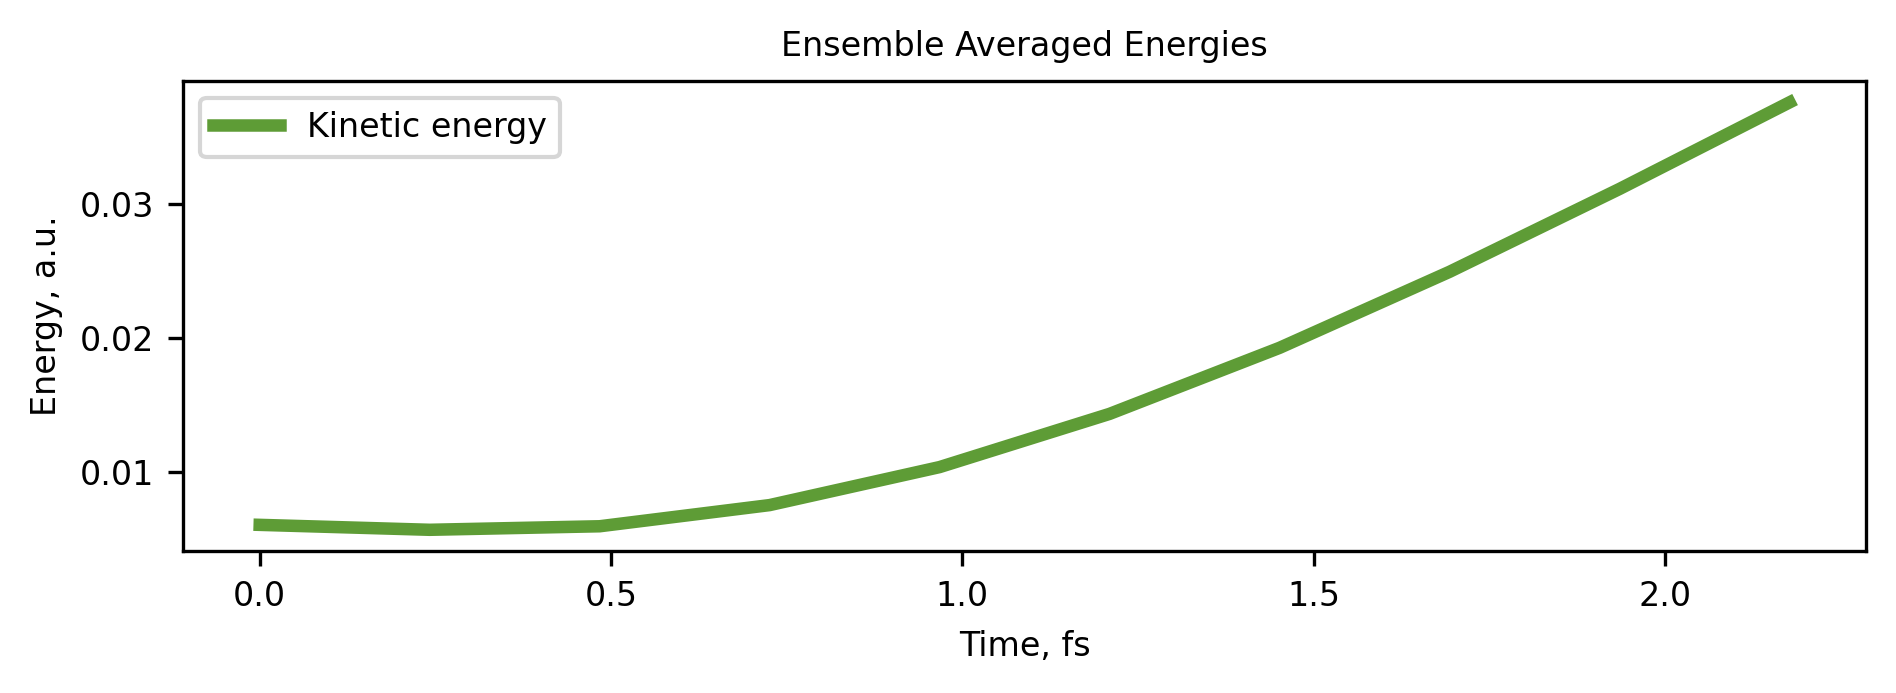

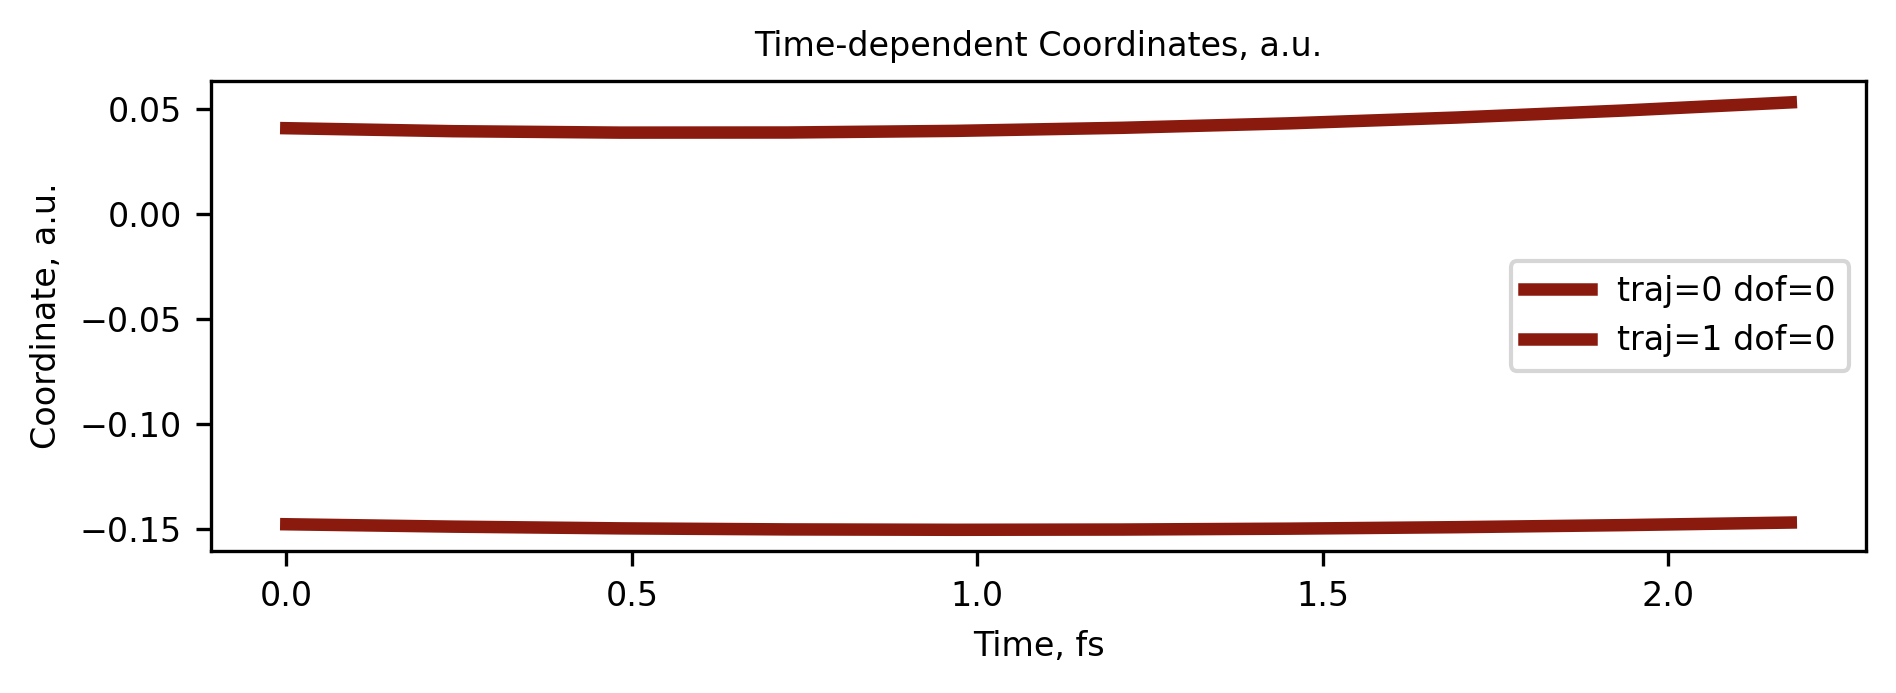

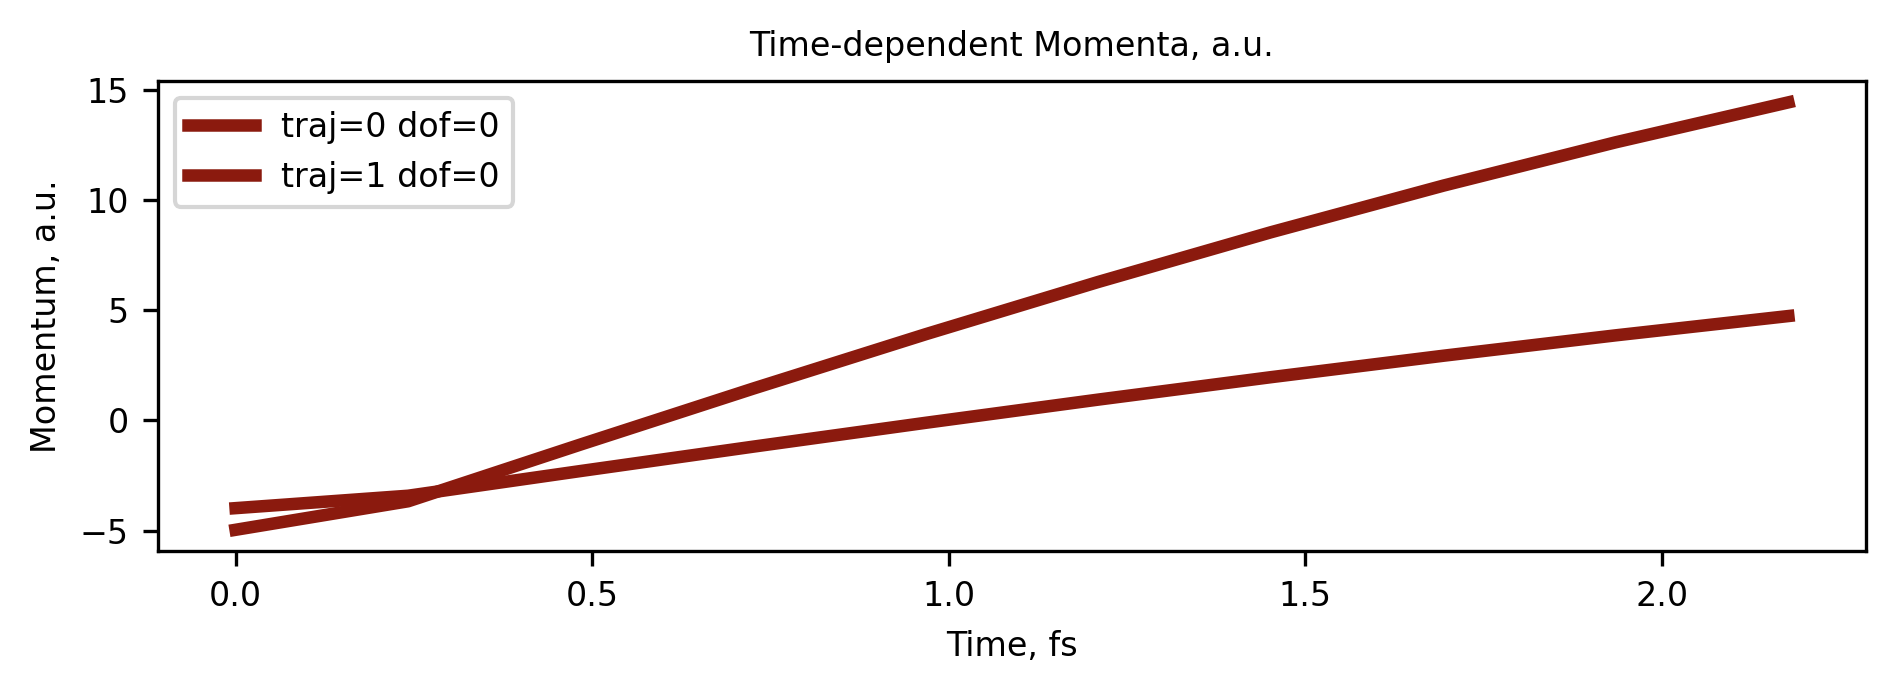

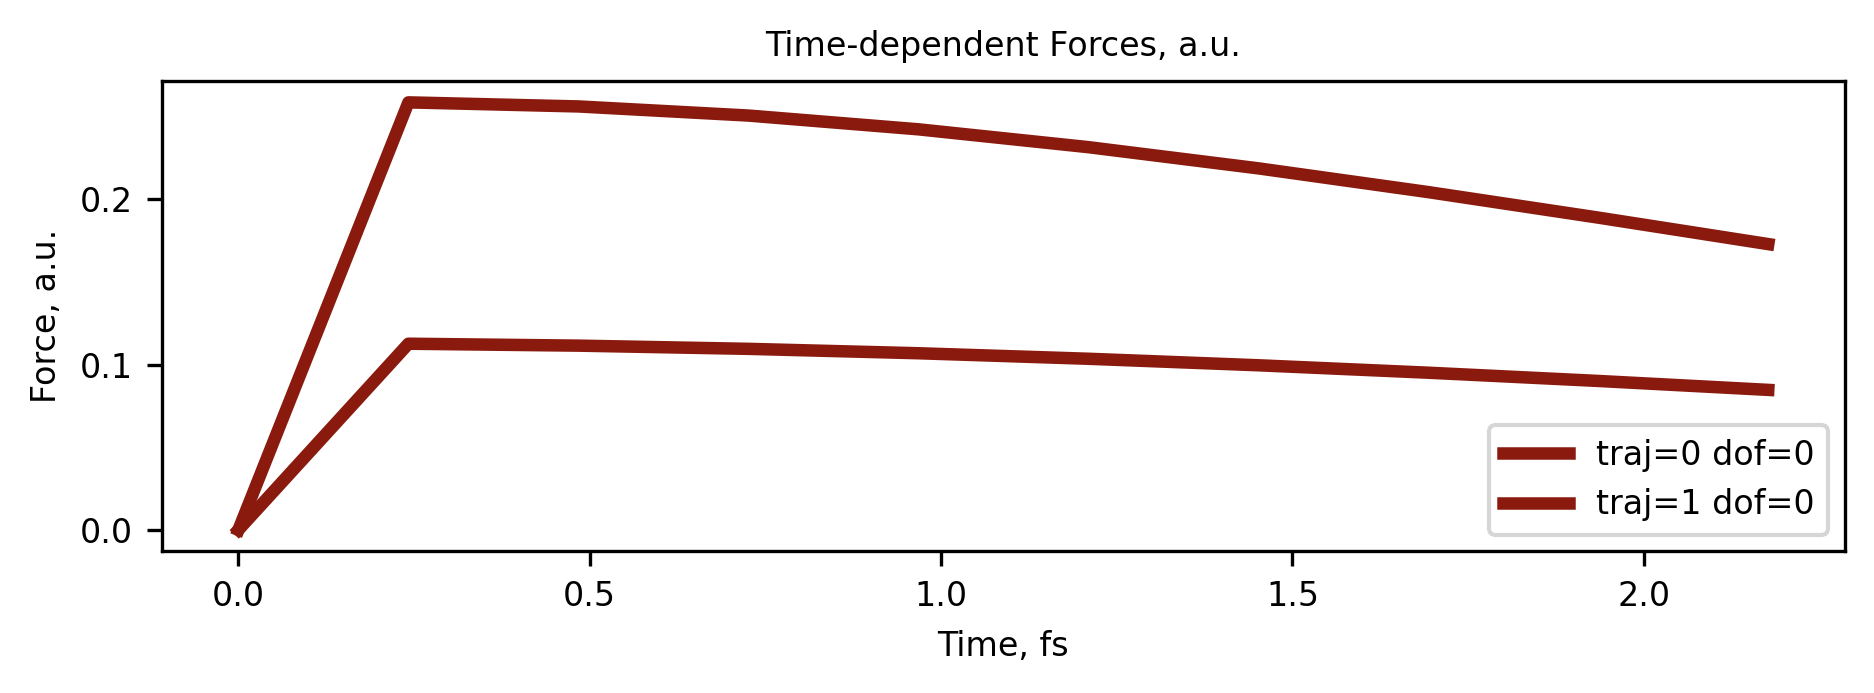

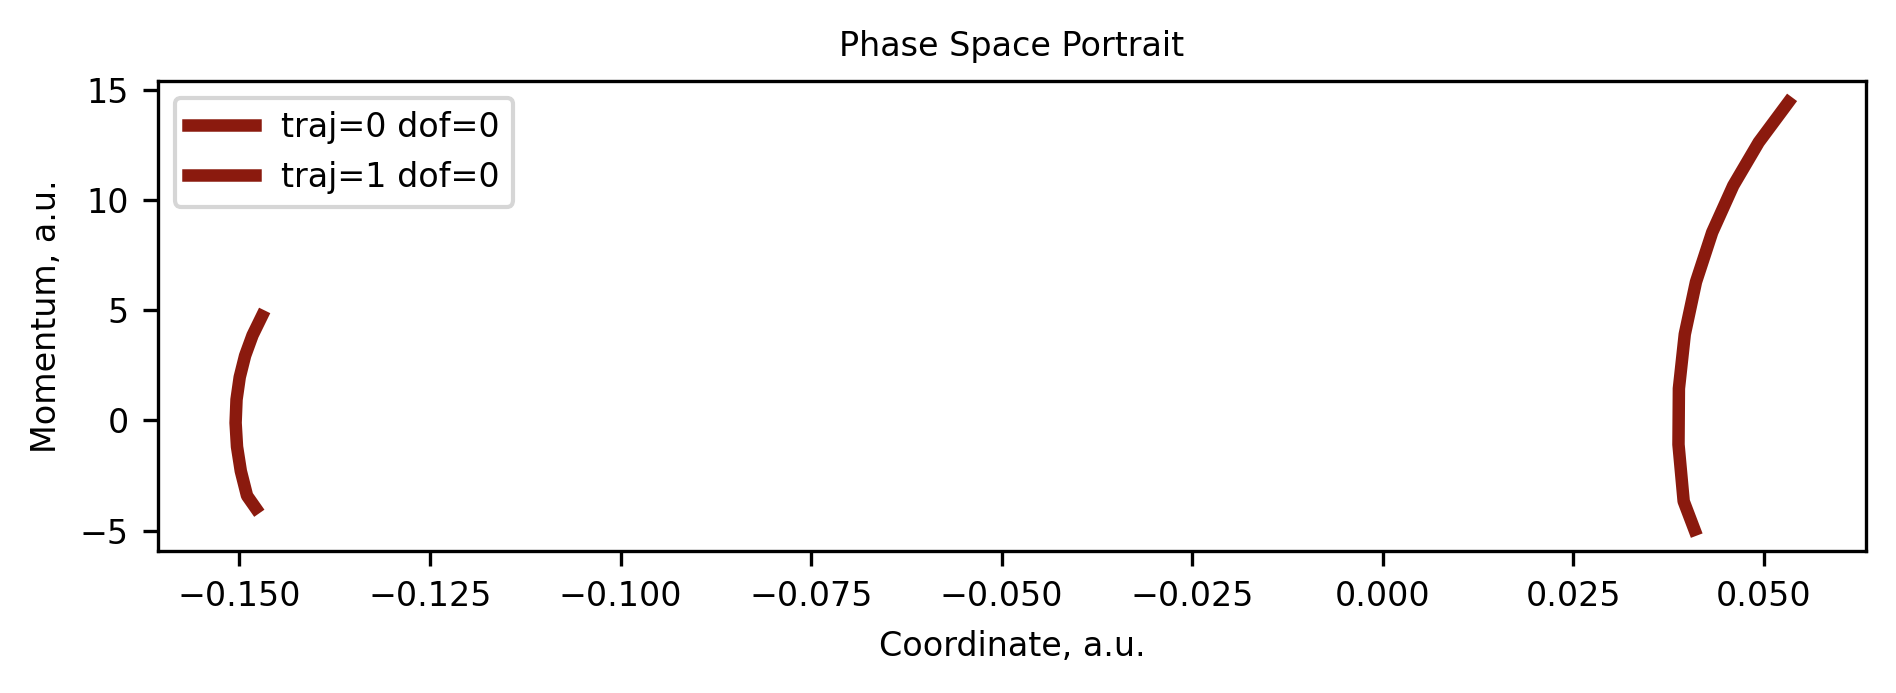

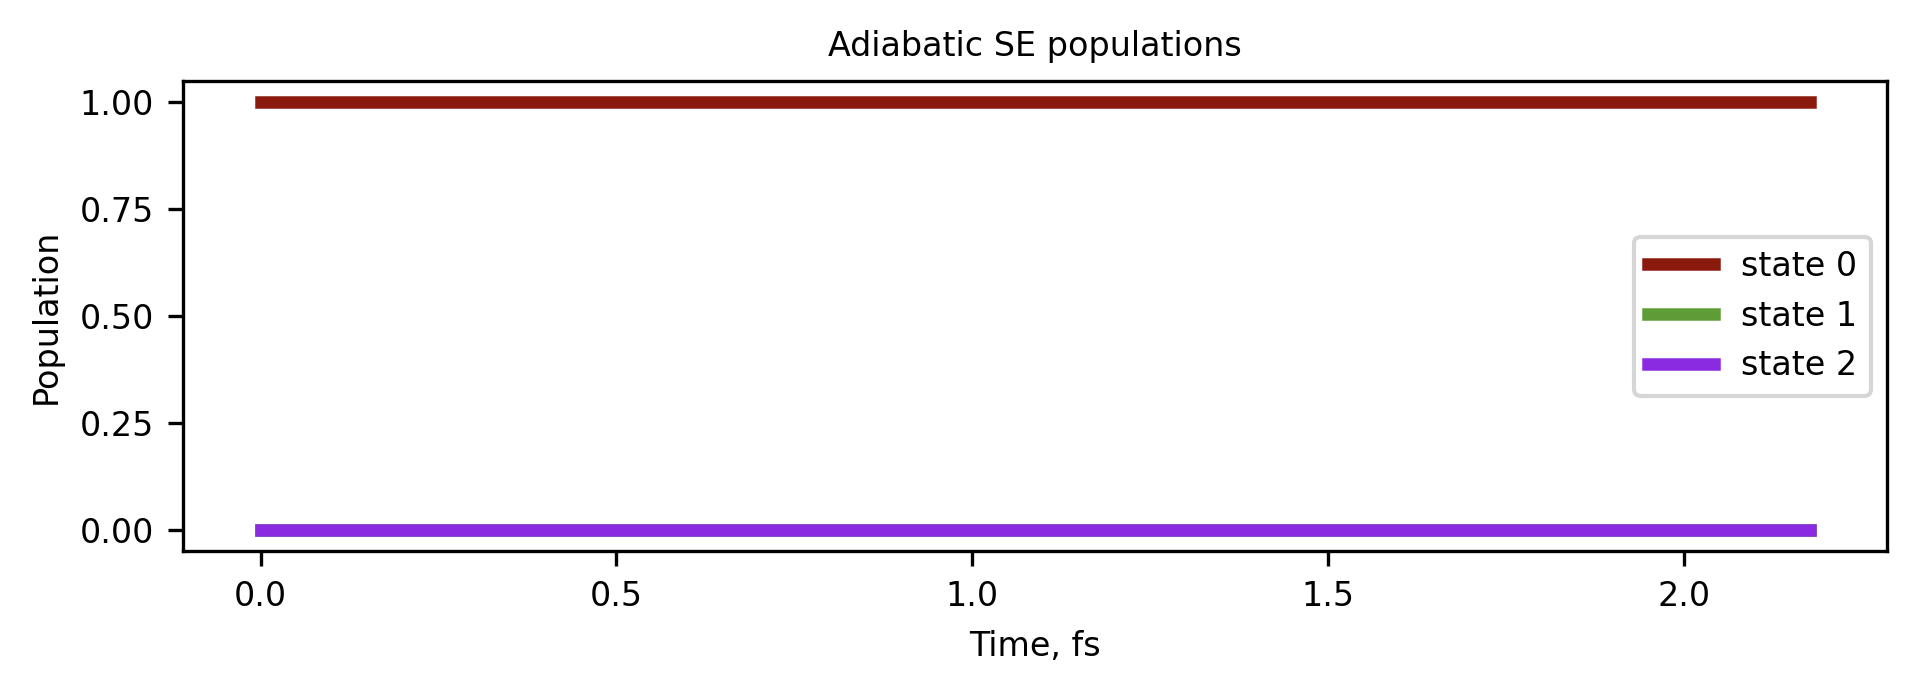

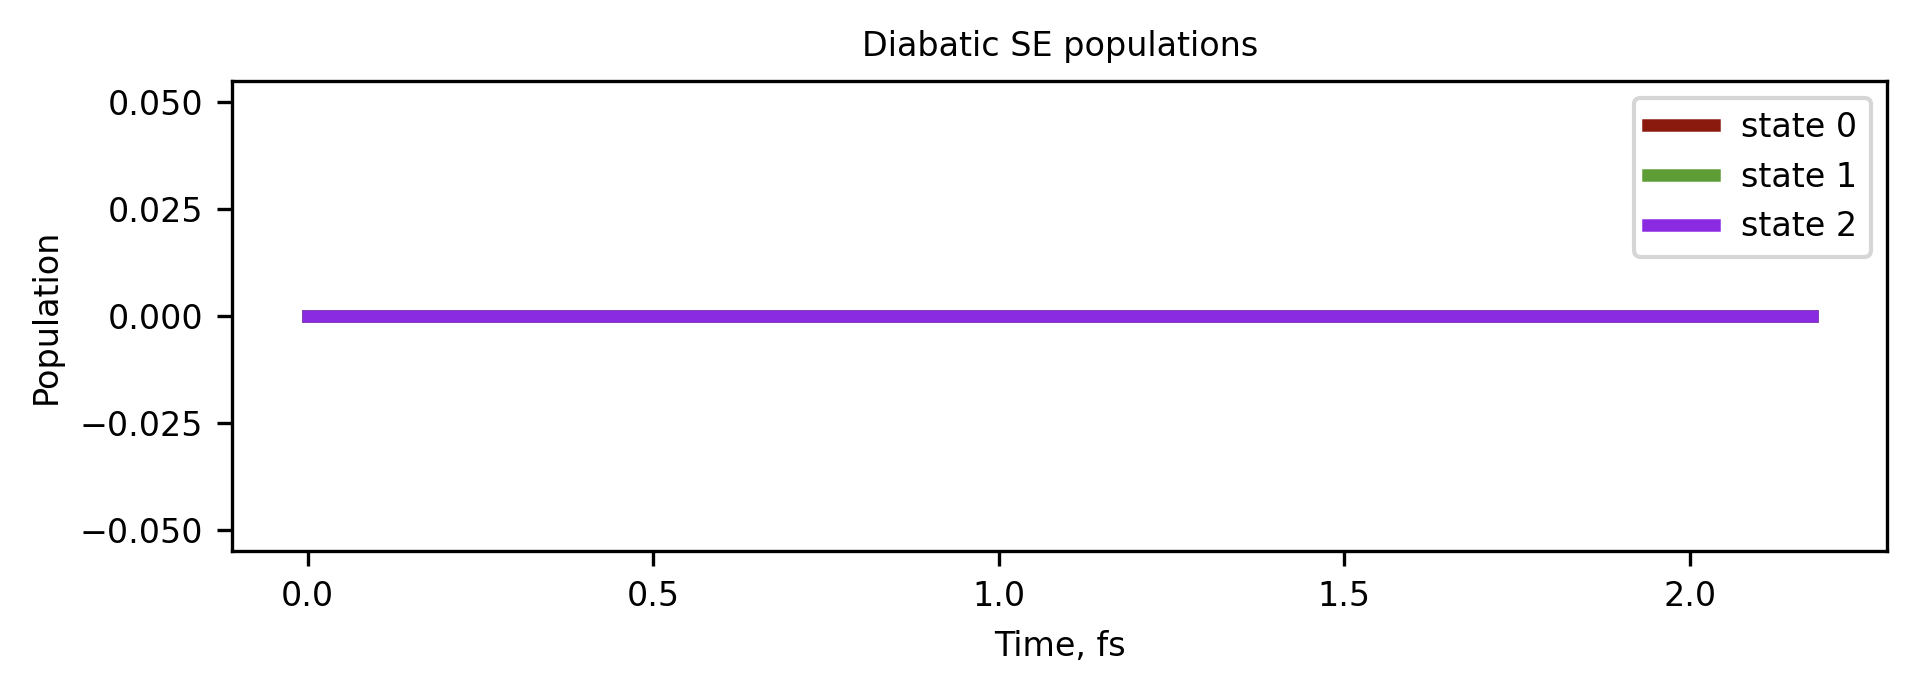

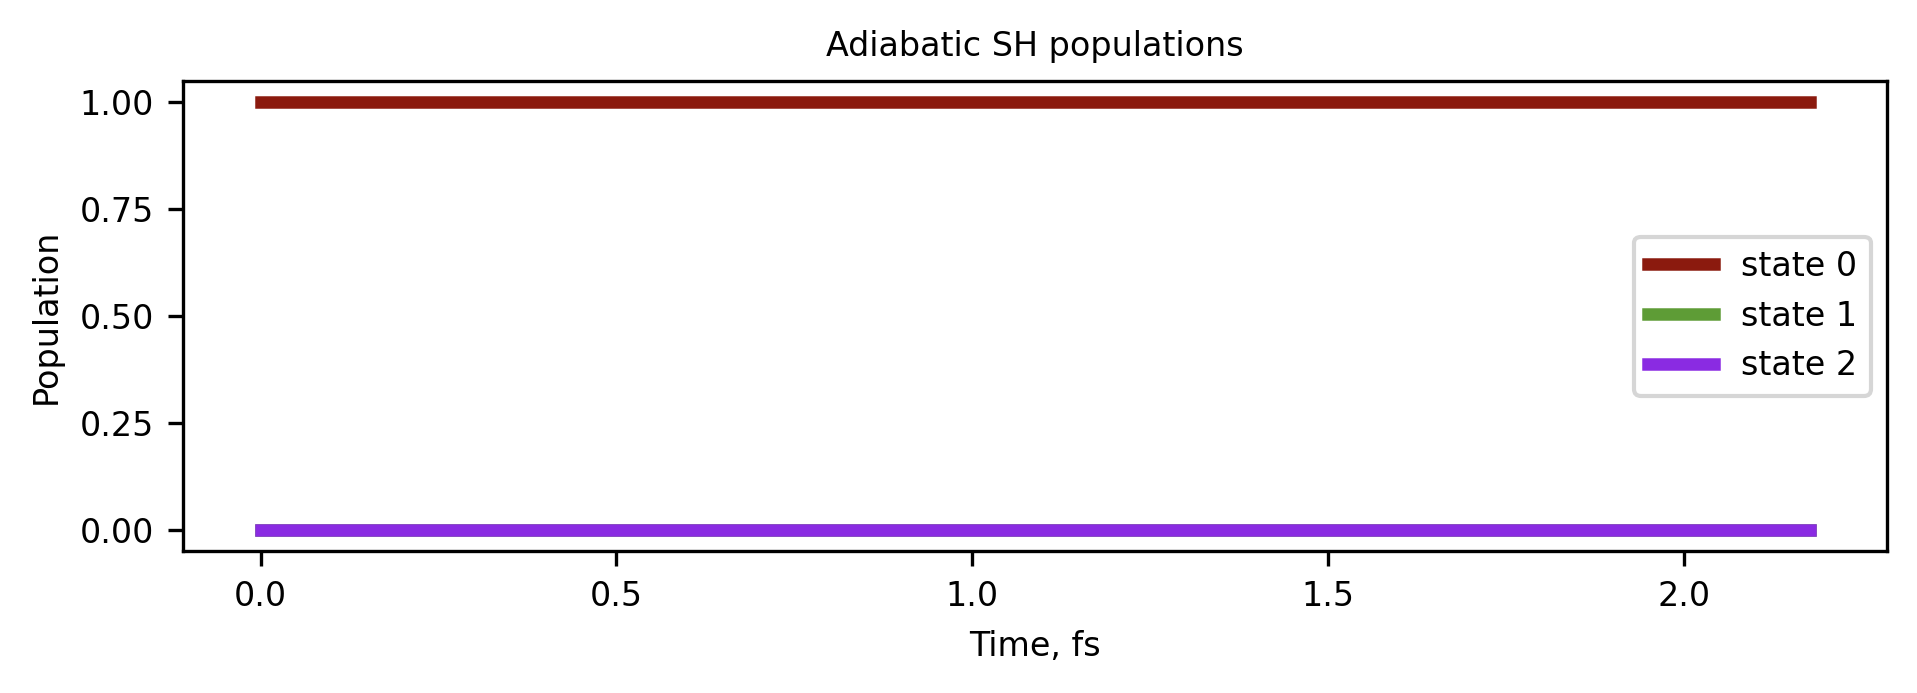

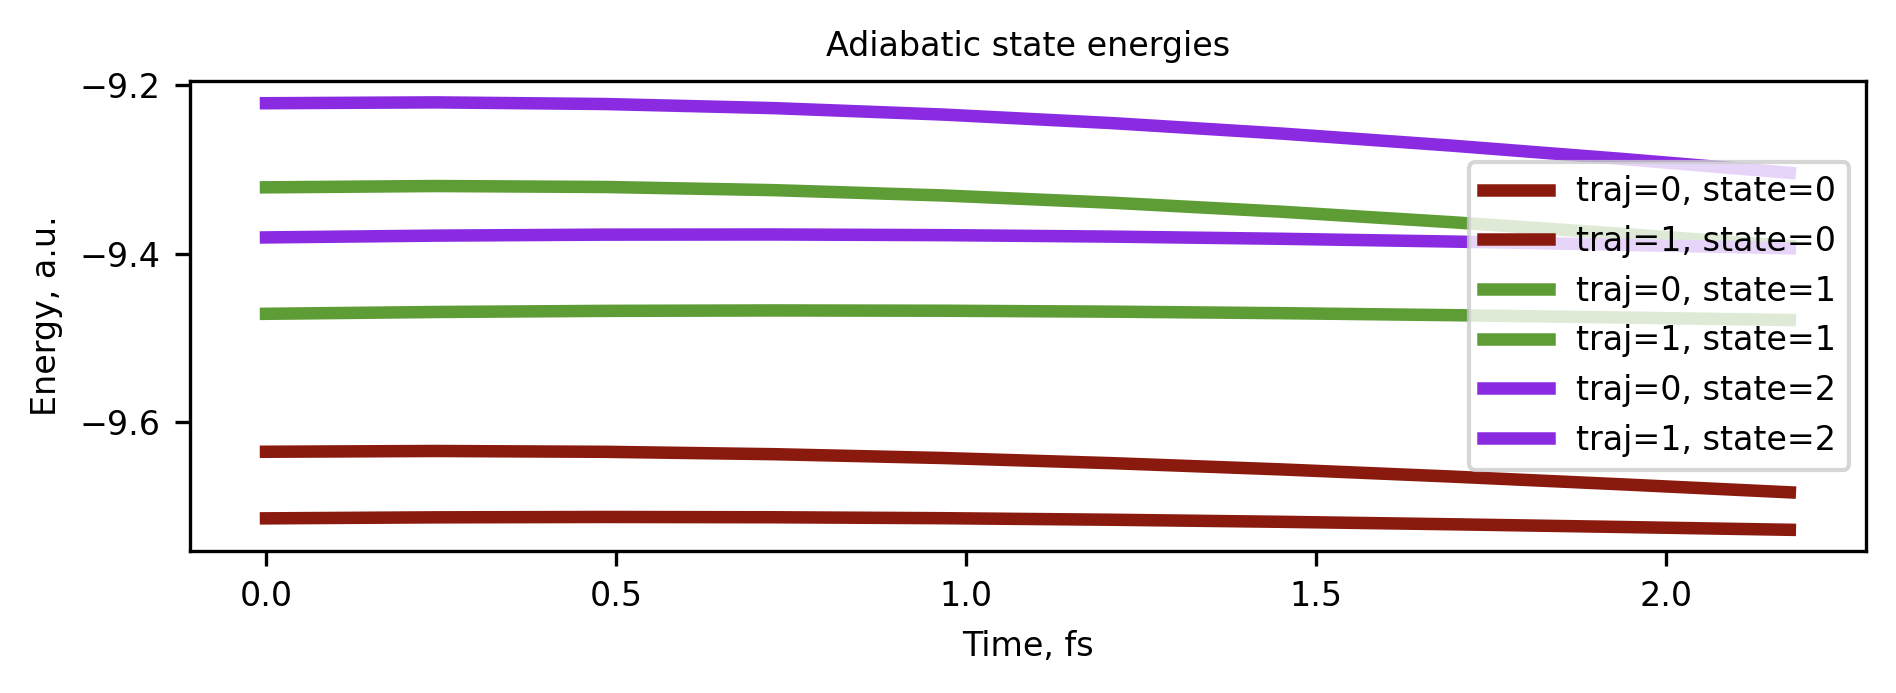

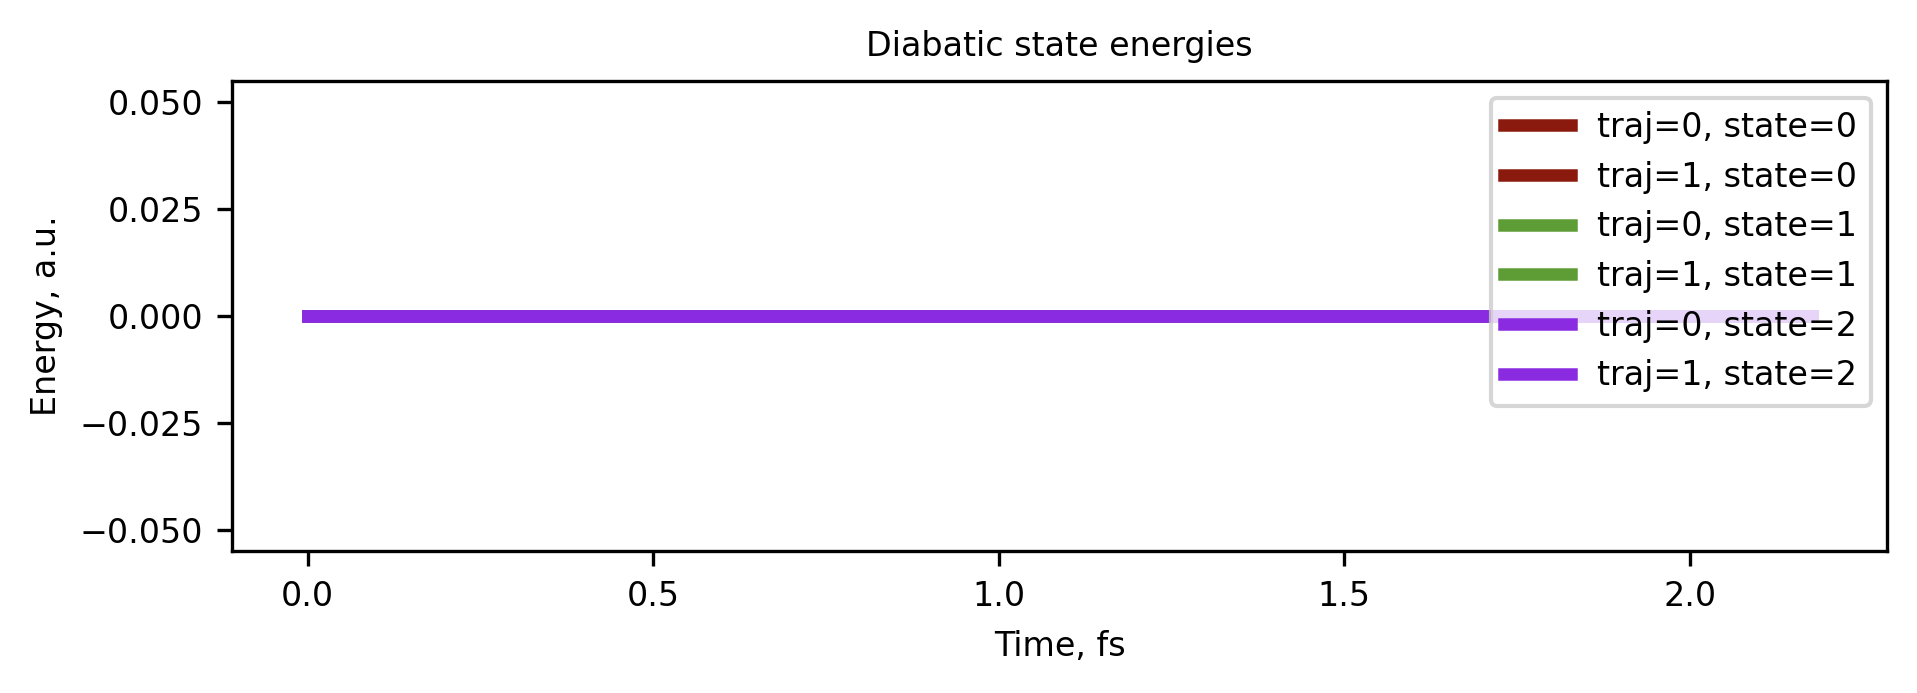

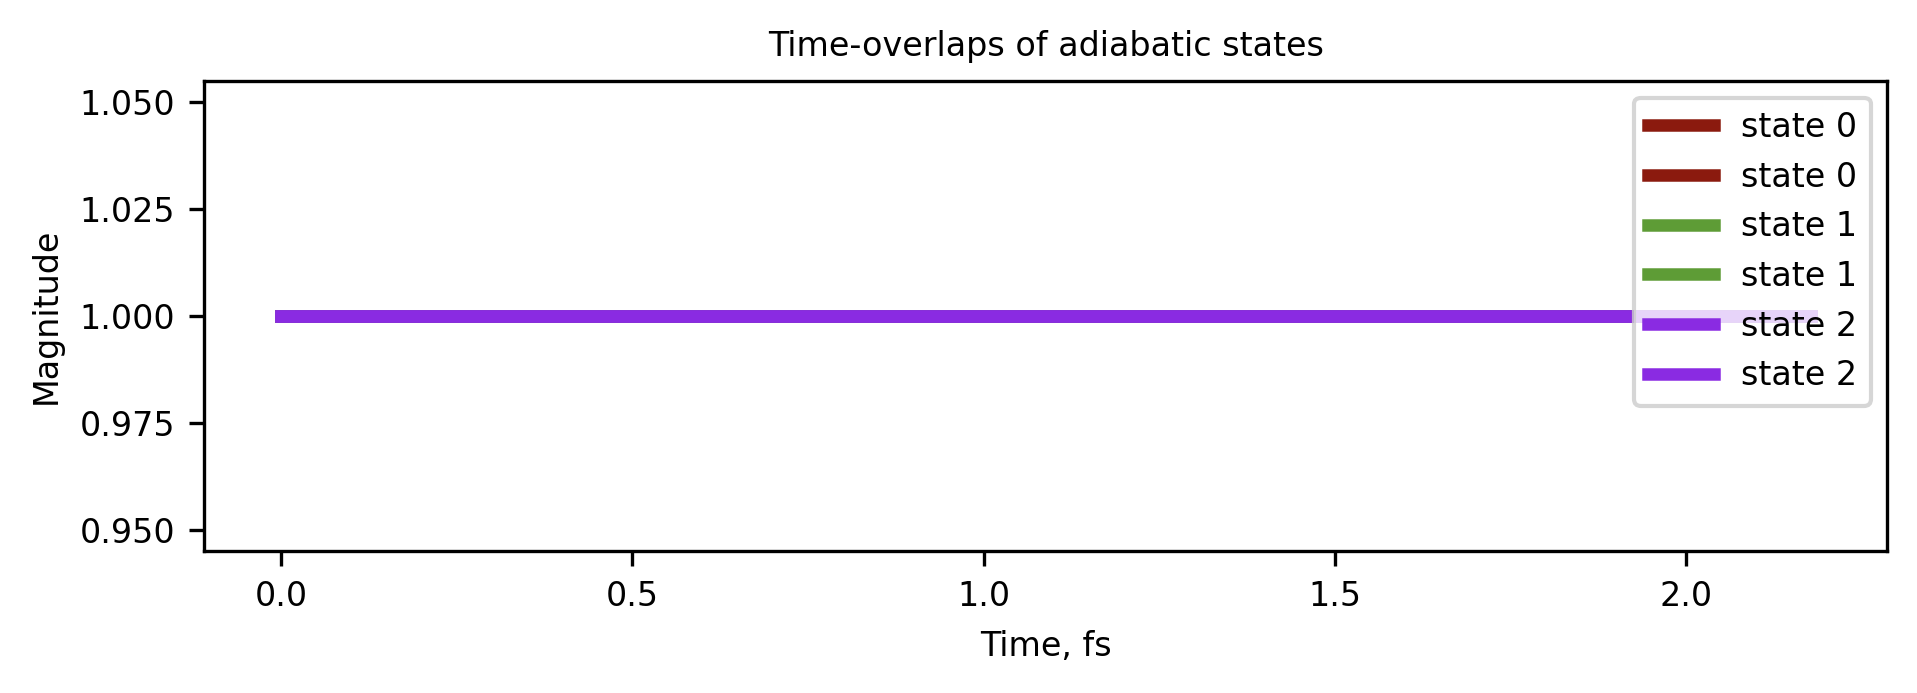

In [29]:
plot_params = { "prefix":"adiabatic_md", "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":[0, 1], "which_dofs":[0], "which_adi_states":[0,1,2], "which_dia_states":[0,1,2], 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
                                "se_pop_dia", "sh_pop_adi", "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham", 
                                "time_overlaps"
                               ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":1
              }

plot.plot_dynamics(plot_params)

<a name="gs-md-vis"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.6. Visualize MD trajectories

In this section, we show how one can visualize the trajectories just comuted.

First, lets define an auxiliary function to read the coordinates from the HDF5 files generated by the `compute.run_dynamics` function. The purpose, input, and the output of this function are described in its docstring, so it shall be pretty self-explanatory.

Don't worry - if we need to re-use such a function elsewhere, it is now included in the `libra_py.dynamics.hsh.plot` module. 

The current one is here for if you want to play around with reading in the HDF5 files. For instance, note how we get access to the coordinates:

* we need to know the name of the data set "q"

* every data set has a subset called "data" - this is a standard practice in Libra, so we really access the coordinates via "q/data", not just "q"

* note the dimensions of this dataset - it is a 3D numpy array of the size: `nsteps x ntraj x ndof`. To learn more about the shapes of other saved data, refer to `save.init_tsh_data` function.

* the 3-rd dimension of the "q/data" dataset stores the DOFs - in this case the Cartesian components - so we need to unpack them to xyz format
<a name="hdf2xyz-ex1"></a>

In [19]:
def hdf2xyz(labels, filename, snaps, trajectories, atoms, unit_conversion_factor=1.0):
    """
    This function creates a string containing an xyz-formatted trajectory (multiple geometries)
    from an HDF5 file produced by the `compute.run_dynamics` function

    Args:
        labels ( list of strings ): the labels of the atoms of the system, the labels are in a 
            specific order that corresponds to the atomic order in the system. The length of this 
            list should be `nat` - the number of atoms listed in the xyz header, even if not all of 
            them are listed in the input parameter `atoms`
        filename ( string ): the name of the HDF5 file that contains the geometry 
        snaps ( list of ints ): indices of the timesteps to be included in the xyz file being generated.
            This allows printing only simesteps of interest. 
        trajectories ( list of ints ): indices of the trajectories that we want to include in the xyz file. 
            This allows plotting many trajectories at once (in every frame).
        atoms ( list of ints ): indices of the atomic species to be printed out to the xyz files (e.g. to 
            eventually visualize). This allows for visualizing only a subset of atoms (e.g. a spatial region,
            a molecule, a group, etc.) of the main interest.
        unit_conversion_factor ( double ): the conversion factor to convert the data stored in the
            HDF5 file to the new units. Since `compute.run_dynamics` function stores all the information
            in the atomic units (Bohrs for the coordinates) and since the xyz files visualization works
            best in the Angstrom units, it is common situation to use the 
            `unit_conversion_factor = 1.0/units.Angst` conversion factor.
 
    Returns:
        string: the string representation of the xyz trajectory file that is made of the 
            provided input geomtries/trajectories/atomic labels 
    
    """
    
    natoms = len(atoms)  # the actual number of atoms to show 
    ntraj = len(trajectories)
    
    md_xyz = ""
    
    with h5py.File(filename, 'r') as f:
    
        for isnap in snaps:
            
            md_xyz = md_xyz + F"{natoms*ntraj}\nsnapshot {isnap}\n"
            
            for itraj in trajectories:
                for iatom in atoms:
                
                    x = f["q/data"][isnap, itraj, 3*iatom+0] * unit_conversion_factor
                    y = f["q/data"][isnap, itraj, 3*iatom+1] * unit_conversion_factor
                    z = f["q/data"][isnap, itraj, 3*iatom+2] * unit_conversion_factor
    
                    md_xyz = md_xyz + F"{labels[iatom] }  {x} {y} {z}\n"                    
    
    return md_xyz

And here is how we can use the function defined above:

* our system is an HFCO molecule, with atoms going like: F - 1-st, C - 2-nd, H - 3-rd, O - 4-th, so this is what defines the `labels` list

* the filename we are going to read is "out/mem_data.hdf"

* we request to print out all the integration timesteps - the `snaps` variable

* we can visualize several trajectories at once - so `trajectories = [0, 1]`. Visualizing many trajectories at once may look pretty weird sometimes, but it gives you a better story about the statistics of dynamical realization/samplings. It can be pretty cluttered too, but showing just 2 trajectories is okay.

* `atoms = [0, 1, 2, 3]` - we choose to show all the atoms of the molecule, but we could have chosed any sub-set of atoms.
<a name="hdf2xyz-ex2"></a>

In [21]:
labels = ["F", "C", "H", "O"]
filename = "adiabatic_md/mem_data.hdf"
snaps = list(range(0, 10))
trajectories = [0, 1]
atoms = [0, 1, 2, 3] # all atoms
unit_conversion_factor = 1.0/units.Angst # convert to Angstrom

xyz = hdf2xyz(labels, filename, snaps, trajectories, atoms, unit_conversion_factor)

The finction `hdf2xyz` generated a string that contains an MD trajectory in the xyz format. We can print this string

In [22]:
print(xyz)

8
snapshot 0
F  -0.07824574577419174 0.68836073664005 1.0984547562004376
C  -0.5797238483549798 0.7806980023591742 0.03305756573722964
H  0.05801816981178329 0.8477178978137776 -0.754002605824744
O  -1.7391099319997974 0.776533783826638 -0.11003690931328348
F  0.021657819243802463 0.6276043252204201 1.0191070118613728
C  -0.5900476140534054 0.9171576733430293 0.1347961242930812
H  0.07850941314527318 1.1754628566946077 -0.712493301347457
O  -1.6438582569665368 0.818120474478733 -0.023549888543001152
8
snapshot 1
F  -0.07884957178686929 0.6881132685621619 1.098304747376366
C  -0.5817984726329967 0.7798014129224115 0.03385120071410421
H  0.05920772137627968 0.8478730601195409 -0.7435413821773733
O  -1.7395042196582358 0.7764641876454507 -0.11139849625821666
F  0.020905051652834235 0.6271597164896938 1.0187272173436717
C  -0.5896340040808407 0.9167023489643735 0.13418219682616012
H  0.08348192269091301 1.175402337696289 -0.7045836793857058
O  -1.6432002903084126 0.8167689416368178 -0.0237

And finally, we can visualize the trajectory with the help of the py3Dmol extension

In [28]:
view = py3Dmol.view(width=800,height=400)  
view.setBackgroundColor('0xeeeeee')                                     
view.zoomTo()                                                           
view.addModelsAsFrames(xyz, 'xyz')
view.setStyle({'sphere':{'colorscheme':'Jmol', }})                        
view.animate({'reps':0, 'loop':'forward', 'step':1})
view.show()  

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<a name="ex-dynamics"></a> [Back to TOC](#TOC)
## 3. Adiabatic dynamics on the excited state

In this section, we are going to do everything as above, but only using the excited state PES to drive the dynamics of the HFCO molecule.

With the help of various auxiliary finctions and Libra modules, we are going to make this section as compact as possible, but self-contained, so you can copy-paaste and use it as a template for other calculations.

In [32]:
# Initialize electronic variables
elec_params = { "verbosity":2, "init_dm_type":0,
              "ndia":3, "nadi":3, "istates":[0.0, 1.0, 0.0],
              "rep":1, "init_type":3
              }

dyn_params = dict(dyn_general)
dyn_params.update({"prefix":"hfco-ex1", "prefix2":"hfco-ex1"})

rnd = Random()
res = compute.generic_recipe(dyn_params, DFTB_methods.run_dftb_adi, ham_params, elec_params, nucl_params, rnd)

not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
========== ampl_dia ===============
(0.0000000,0.0000000)  (0.0000000,0.0000000)  
(0.0000000,0.0000000)  (0.0000000,0.0000000)  
(0.0000000,0.0000000)  (0.0000000,0.0000000)  

========== ampl_adi ===============
(-0.0000000,-0.0000000)  (-0.0000000,0.0000000)  
(-0.36179555,0.93225746)  (-0.13079091,0.99140998)  
(0.0000000,-0.0000000)  (-0.0000000,0.0000000)  

|===============================================================================
|
|  DFTB+ development version (commit: 3f79963e, base: 22.2)
|
|  Copyright (C) 2006 - 2022  DFTB+ developers group
|
|===================================


Total Energy:                       -9.5356820135 H         -259.4791 eV
Extrapolated to 0K:                 -9.5356820135 H         -259.4791 eV
Total Mermin free energy:           -9.5356820135 H         -259.4791 eV
Force related energy:               -9.5356820135 H         -259.4791 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.64 ( 70.0%)       0.42 ( 68.2%)
Post-SCC processing                    +       2.83 ( 29.8%)       0.18 ( 29.2%)
--------------------------------------------------------------------------------
Missing                                +       0.01 (  0.1%)       0.02 (  2.6%)
Total                                  =       9.48 (100.0%)       0.61 (100.0%)
----------------------------------------------------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523287844
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self

    1    0.00000000E+00    0.00000000E+00    0.10268683E+01
    2   -0.98796004E+01   -0.98796004E+01    0.74278458E+00
    3   -0.98941261E+01   -0.14525687E-01    0.94813410E-01
    4   -0.99051863E+01   -0.11060242E-01    0.15755131E+00
    5   -0.99048820E+01    0.30434613E-03    0.13686051E-01
    6   -0.99061817E+01   -0.12996840E-02    0.11257752E-01
    7   -0.99061858E+01   -0.40925863E-05    0.14930693E-03
    8   -0.99061938E+01   -0.80954403E-05    0.85931321E-06
    9   -0.99061939E+01   -0.13828014E-08    0.11496379E-07
   10   -0.99061939E+01   -0.35527137E-13    0.33306691E-12
>> Charges saved for restart in charges.bin

Total Energy:                       -9.7375148768 H         -264.9713 eV
Extrapolated to 0K:                 -9.7375148768 H         -264.9713 eV
Total Mermin free energy:           -9.7375148768 H         -264.9713 eV
Force related energy:               -9.7375148768 H         -264.9713 eV


-------------------------------------------------------------

    1    0.00000000E+00    0.00000000E+00    0.10268683E+01
    2   -0.98796004E+01   -0.98796004E+01    0.74278458E+00
    3   -0.98941261E+01   -0.14525687E-01    0.94813410E-01
    4   -0.99051863E+01   -0.11060242E-01    0.15755131E+00
    5   -0.99048820E+01    0.30434613E-03    0.13686051E-01
    6   -0.99061817E+01   -0.12996840E-02    0.11257752E-01
    7   -0.99061858E+01   -0.40925863E-05    0.14930693E-03
    8   -0.99061938E+01   -0.80954403E-05    0.85931321E-06
    9   -0.99061939E+01   -0.13828014E-08    0.11496379E-07
   10   -0.99061939E+01   -0.35527137E-13    0.33306691E-12
>> Charges saved for restart in charges.bin

Total Energy:                       -9.4263876901 H         -256.5051 eV
Extrapolated to 0K:                 -9.7375148768 H         -264.9713 eV
Total Mermin free energy:           -9.4263876901 H         -256.5051 eV
Force related energy:               -9.7375148768 H         -264.9713 eV


-------------------------------------------------------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523292294
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self

    5   -0.99648408E+01    0.53410183E-03    0.21025354E-01
    6   -0.99666767E+01   -0.18358724E-02    0.24567802E-01
    7   -0.99666662E+01    0.10496306E-04    0.14389793E-02
    8   -0.99666979E+01   -0.31708266E-04    0.89294759E-05
    9   -0.99666980E+01   -0.11241147E-06    0.10423287E-06
   10   -0.99666980E+01   -0.41779913E-11    0.66089356E-11
>> Charges saved for restart in charges.bin

Total Energy:                       -9.2046239292 H         -250.4706 eV
Extrapolated to 0K:                 -9.5356672602 H         -259.4787 eV
Total Mermin free energy:           -9.2046239292 H         -250.4706 eV
Force related energy:               -9.5356672602 H         -259.4787 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
Pre-SCC initialisation                 +       0.02 (  0.2%

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523294752
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self

    8   -0.99089751E+01   -0.79904279E-05    0.56464367E-06
    9   -0.99089751E+01   -0.10160850E-08    0.94945207E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -9.4261372094 H         -256.4982 eV
Extrapolated to 0K:                 -9.7381885651 H         -264.9896 eV
Total Mermin free energy:           -9.4261372094 H         -256.4982 eV
Force related energy:               -9.7381885651 H         -264.9896 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.71 ( 71.1%)       0.44 ( 71.5%)
Post-SCC processing                    +       2.73 ( 28.9%)       0.17 ( 26.9%)
--------------------------------------------------------------------------------
Missing                                +       0.00 (  0

OpenMP threads:              16
Chosen random seed:          523297637
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self consistent charges:     Yes
SCC-tolerance:                 0.100000E-07
Max. scc iterations:                    100
Shell resolved Hubbard:      No
Spin polarisation:           No
Nr. of up electrons:             9.000000
Nr. of down electrons:           9.000000
Periodic boundaries:         No
Electronic solver:           Relatively robust
Casida solver:               Arpack
Mixer:                       Broyden mixer
Mixing parameter:                  0.200000
Maximal SCC-cycles:                     100
Nr. of chrg. vec. 

|===============================================================================
|
|  DFTB+ development version (commit: 3f79963e, base: 22.2)
|
|  Copyright (C) 2006 - 2022  DFTB+ developers group
|
|===============================================================================
|
|  When publishing results obtained with DFTB+, please cite the following
|  reference:
|
|  * DFTB+, a software package for efficient approximate density functional
|    theory based atomistic simulations, J. Chem. Phys. 152, 124101 (2020).
|    [doi: 10.1063/1.5143190]
|
|  You should also cite additional publications crediting the parametrization
|  data you use. Please consult the documentation of the SK-files for the
|  references.
|
|===============================================================================

Reading input file 'dftb_in.hsd'
Parser version: 13

--------------------------------------------------------------------------------
***  Converting input from parser version  4 to parser ver

    1    0.00000000E+00    0.00000000E+00    0.10214773E+01
    2   -0.98848040E+01   -0.98848040E+01    0.73884641E+00
    3   -0.98990318E+01   -0.14227751E-01    0.91951144E-01
    4   -0.99100017E+01   -0.10969958E-01    0.15025470E+00
    5   -0.99097732E+01    0.22849065E-03    0.15643671E-01
    6   -0.99109391E+01   -0.11658638E-02    0.11235802E-01
    7   -0.99109468E+01   -0.77404325E-05    0.10790280E-03
    8   -0.99109548E+01   -0.79990956E-05    0.31092488E-06
    9   -0.99109548E+01   -0.73561246E-09    0.64064167E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -9.5151026490 H         -258.9191 eV
Extrapolated to 0K:                 -9.7387457480 H         -265.0048 eV
Total Mermin free energy:           -9.5151026490 H         -258.9191 eV
Force related energy:               -9.7387457480 H         -265.0048 eV


--------------------------------------------------------------------------------
DFTB+ running times                     

    1    0.00000000E+00    0.00000000E+00    0.98637620E+00
    2   -0.99164334E+01   -0.99164334E+01    0.69631854E+00
    3   -0.99370085E+01   -0.20575108E-01    0.11361501E+00
    4   -0.99547388E+01   -0.17730343E-01    0.20503050E+00
    5   -0.99540392E+01    0.69967601E-03    0.22752660E-01
    6   -0.99560938E+01   -0.20546181E-02    0.24875702E-01
    7   -0.99560868E+01    0.69322055E-05    0.12215983E-02
    8   -0.99561203E+01   -0.33455964E-04    0.40125708E-05
    9   -0.99561204E+01   -0.83593145E-07    0.11666958E-06
   10   -0.99561204E+01   -0.83488771E-12    0.13447021E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.5596661884 H         -260.1318 eV
Extrapolated to 0K:                 -9.5596661884 H         -260.1318 eV
Total Mermin free energy:           -9.5596661884 H         -260.1318 eV
Force related energy:               -9.5596661884 H         -260.1318 eV


-------------------------------------------------------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523303965
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self

    8   -0.99121103E+01   -0.81304290E-05    0.77870913E-07
    9   -0.99121103E+01   -0.52008531E-09    0.24926781E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -9.7391786588 H         -265.0165 eV
Extrapolated to 0K:                 -9.7391786588 H         -265.0165 eV
Total Mermin free energy:           -9.7391786588 H         -265.0165 eV
Force related energy:               -9.7391786588 H         -265.0165 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       4.83 ( 61.7%)       0.31 ( 61.7%)
Post-SCC processing                    +       2.99 ( 38.2%)       0.19 ( 36.5%)
--------------------------------------------------------------------------------
Missing                                +       0.01 (  0

 iSCC Total electronic   Diff electronic      SCC error    
    1    0.00000000E+00    0.00000000E+00    0.10194626E+01
    2   -0.98859543E+01   -0.98859543E+01    0.73691962E+00
    3   -0.99001652E+01   -0.14210954E-01    0.90947116E-01
    4   -0.99111745E+01   -0.11009322E-01    0.14853743E+00
    5   -0.99109571E+01    0.21746953E-03    0.16586649E-01
    6   -0.99120926E+01   -0.11355665E-02    0.11333041E-01
    7   -0.99121021E+01   -0.94769181E-05    0.89938497E-04
    8   -0.99121103E+01   -0.81304290E-05    0.77870913E-07
    9   -0.99121103E+01   -0.52008531E-09    0.24926781E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -9.4271749515 H         -256.5265 eV
Extrapolated to 0K:                 -9.7391786588 H         -265.0165 eV
Total Mermin free energy:           -9.4271749515 H         -256.5265 eV
Force related energy:               -9.7391786588 H         -265.0165 eV


-------------------------------------------------------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523308686
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit b

    4   -0.99466154E+01   -0.17457383E-01    0.21071739E+00
    5   -0.99457898E+01    0.82563646E-03    0.24247933E-01
    6   -0.99479957E+01   -0.22059757E-02    0.24816418E-01
    7   -0.99479925E+01    0.32663088E-05    0.10022441E-02
    8   -0.99480265E+01   -0.34008236E-04    0.12195582E-05
    9   -0.99480265E+01   -0.57615953E-07    0.10335102E-06
   10   -0.99480265E+01   -0.65725203E-13    0.13722357E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.2645572350 H         -252.1014 eV
Extrapolated to 0K:                 -9.5804374848 H         -260.6970 eV
Total Mermin free energy:           -9.2645572350 H         -252.1014 eV
Force related energy:               -9.5804374848 H         -260.6970 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523311234
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self

    9   -0.99124237E+01   -0.35235637E-09    0.19237980E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -9.4284549502 H         -256.5613 eV
Extrapolated to 0K:                 -9.7394857344 H         -265.0249 eV
Total Mermin free energy:           -9.4284549502 H         -256.5613 eV
Force related energy:               -9.7394857344 H         -265.0249 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.75 ( 71.4%)       0.44 ( 70.8%)
Post-SCC processing                    +       2.66 ( 28.2%)       0.17 ( 27.2%)
Post-geometry optimisation             +       0.04 (  0.4%)       0.00 (  0.2%)
--------------------------------------------------------------------------------
Missing                            

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523314037
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit b

    5   -0.99358714E+01    0.97933629E-03    0.26010907E-01
    6   -0.99382546E+01   -0.23832006E-02    0.24571150E-01
    7   -0.99382566E+01   -0.20398629E-05    0.72477873E-03
    8   -0.99382908E+01   -0.34178951E-04    0.71540386E-06
    9   -0.99382908E+01   -0.31075331E-07    0.60098024E-07
   10   -0.99382908E+01   -0.37303494E-13    0.82511775E-11
>> Charges saved for restart in charges.bin

Total Energy:                       -9.2951365706 H         -252.9335 eV
Extrapolated to 0K:                 -9.6039387302 H         -261.3365 eV
Total Mermin free energy:           -9.2951365706 H         -252.9335 eV
Force related energy:               -9.6039387302 H         -261.3365 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.89 ( 71.2%

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-C.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523316854
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
  

    8   -0.99118841E+01   -0.88189847E-05    0.38631732E-06
    9   -0.99118841E+01   -0.22027713E-09    0.63215575E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -9.4302278333 H         -256.6096 eV
Extrapolated to 0K:                 -9.7396711928 H         -265.0299 eV
Total Mermin free energy:           -9.4302278333 H         -256.6096 eV
Force related energy:               -9.7396711928 H         -265.0299 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       2.90 ( 52.3%)       0.18 ( 50.1%)
Post-SCC processing                    +       2.64 ( 47.6%)       0.17 ( 46.3%)
--------------------------------------------------------------------------------
Missing                                +       0.01 (  0

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523319272
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self

    8   -0.99271032E+01   -0.33925925E-04    0.22538993E-05
    9   -0.99271032E+01   -0.10882403E-07    0.93411687E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -9.3269121519 H         -253.7982 eV
Extrapolated to 0K:                 -9.6278853877 H         -261.9881 eV
Total Mermin free energy:           -9.3269121519 H         -253.7982 eV
Force related energy:               -9.6278853877 H         -261.9881 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       3.79 ( 56.9%)       0.25 ( 57.2%)
Post-SCC processing                    +       2.87 ( 43.0%)       0.18 ( 40.7%)
--------------------------------------------------------------------------------
Missing                                +       0.00 (  0

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523321547
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self

    8   -0.99104830E+01   -0.94150512E-05    0.64535060E-06
    9   -0.99104830E+01   -0.11697487E-09    0.10065451E-07
   10   -0.99104830E+01   -0.19539925E-13    0.57687188E-12
>> Charges saved for restart in charges.bin

Total Energy:                       -9.4324799542 H         -256.6708 eV
Extrapolated to 0K:                 -9.7397456300 H         -265.0320 eV
Total Mermin free energy:           -9.4324799542 H         -256.6708 eV
Force related energy:               -9.7397456300 H         -265.0320 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
Pre-SCC initialisation                 +       0.04 (  0.6%)       0.01 (  1.4%)
SCC                                    +       3.69 ( 58.6%)       0.24 ( 57.8%)
Post-SCC processing                    +       2.55 ( 40.5%)       0.17 ( 39.

 iSCC Total electronic   Diff electronic      SCC error    
    1    0.00000000E+00    0.00000000E+00    0.97508151E+00
    2   -0.98764695E+01   -0.98764695E+01    0.71030435E+00
    3   -0.98969579E+01   -0.20488469E-01    0.11718627E+00
    4   -0.99131574E+01   -0.16199500E-01    0.22967932E+00
    5   -0.99118126E+01    0.13447938E-02    0.30083030E-01
    6   -0.99146028E+01   -0.27901715E-02    0.23577376E-01
    7   -0.99146206E+01   -0.17798338E-04    0.12496249E-03
    8   -0.99146539E+01   -0.33336061E-04    0.40941099E-05
    9   -0.99146539E+01   -0.11019150E-08    0.68409004E-07
   10   -0.99146539E+01   -0.10036416E-11    0.36286529E-11
>> Charges saved for restart in charges.bin

Total Energy:                       -9.4368276986 H         -256.7891 eV
Extrapolated to 0K:                 -9.6504734619 H         -262.6027 eV
Total Mermin free energy:           -9.4368276986 H         -256.7891 eV
Force related energy:               -9.6504734619 H         -262.6027 eV


-

 iSCC Total electronic   Diff electronic      SCC error    
    1    0.00000000E+00    0.00000000E+00    0.10177001E+01
    2   -0.98805676E+01   -0.98805676E+01    0.73082200E+00
    3   -0.98955876E+01   -0.15020003E-01    0.90205696E-01
    4   -0.99072805E+01   -0.11692896E-01    0.15460877E+00
    5   -0.99069430E+01    0.33754804E-03    0.20359377E-01
    6   -0.99081915E+01   -0.12485184E-02    0.12609591E-01
    7   -0.99082068E+01   -0.15325083E-04    0.21228492E-04
    8   -0.99082170E+01   -0.10212393E-04    0.94273223E-06
    9   -0.99082170E+01   -0.42101433E-10    0.12650286E-07
   10   -0.99082170E+01   -0.56843419E-13    0.68167694E-12
>> Charges saved for restart in charges.bin

Total Energy:                       -9.7397186832 H         -265.0312 eV
Extrapolated to 0K:                 -9.7397186832 H         -265.0312 eV
Total Mermin free energy:           -9.7397186832 H         -265.0312 eV
Force related energy:               -9.7397186832 H         -265.0312 eV


-

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523327135
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self

    5   -0.98980653E+01    0.15321763E-02    0.32178834E-01
    6   -0.99010629E+01   -0.29976458E-02    0.22957262E-01
    7   -0.99010906E+01   -0.27657056E-04    0.12334574E-03
    8   -0.99011232E+01   -0.32593996E-04    0.58525799E-05
    9   -0.99011232E+01   -0.83361229E-09    0.59069537E-07
   10   -0.99011232E+01   -0.20801139E-11    0.14424018E-11
>> Charges saved for restart in charges.bin

Total Energy:                       -9.6704840677 H         -263.1473 eV
Extrapolated to 0K:                 -9.6704840677 H         -263.1473 eV
Total Mermin free energy:           -9.6704840677 H         -263.1473 eV
Force related energy:               -9.6704840677 H         -263.1473 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       7.56 ( 70.5%

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523329899
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit b

   10   -0.99050859E+01   -0.10480505E-12    0.80602192E-12
>> Charges saved for restart in charges.bin

Total Energy:                       -9.7395982639 H         -265.0280 eV
Extrapolated to 0K:                 -9.7395982639 H         -265.0280 eV
Total Mermin free energy:           -9.7395982639 H         -265.0280 eV
Force related energy:               -9.7395982639 H         -265.0280 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       4.18 ( 59.7%)       0.27 ( 59.3%)
Post-SCC processing                    +       2.81 ( 40.2%)       0.18 ( 38.6%)
--------------------------------------------------------------------------------
Missing                                +       0.00 (  0.1%)       0.01 (  2.2%)
Total                              

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523332518
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit b


Total Energy:                       -9.6872354463 H         -263.6031 eV
Extrapolated to 0K:                 -9.6872354463 H         -263.6031 eV
Total Mermin free energy:           -9.6872354463 H         -263.6031 eV
Force related energy:               -9.6872354463 H         -263.6031 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       3.33 ( 56.2%)       0.21 ( 54.9%)
Post-SCC processing                    +       2.59 ( 43.7%)       0.17 ( 43.0%)
--------------------------------------------------------------------------------
Missing                                +       0.00 (  0.1%)       0.01 (  2.1%)
Total                                  =       5.93 (100.0%)       0.38 (100.0%)
----------------------------------------------------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523334976
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self

    9   -0.99010934E+01   -0.25409008E-10    0.13337097E-07
   10   -0.99010934E+01   -0.18118840E-12    0.95656816E-12
>> Charges saved for restart in charges.bin

Total Energy:                       -9.7394010819 H         -265.0226 eV
Extrapolated to 0K:                 -9.7394010819 H         -265.0226 eV
Total Mermin free energy:           -9.7394010819 H         -265.0226 eV
Force related energy:               -9.7394010819 H         -265.0226 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       7.65 ( 73.5%)       0.50 ( 73.4%)
Post-SCC processing                    +       2.75 ( 26.4%)       0.17 ( 25.1%)
--------------------------------------------------------------------------------
Missing                                +       0.01 (  0

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523337713
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self

    9   -0.98714717E+01   -0.11330783E-07    0.10718908E-07
   10   -0.98714717E+01   -0.30073721E-11    0.55190963E-10
>> Charges saved for restart in charges.bin

Total Energy:                       -9.7003767359 H         -263.9607 eV
Extrapolated to 0K:                 -9.7003767359 H         -263.9607 eV
Total Mermin free energy:           -9.7003767359 H         -263.9607 eV
Force related energy:               -9.7003767359 H         -263.9607 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       7.75 ( 74.6%)       0.51 ( 74.6%)
Post-SCC processing                    +       2.58 ( 24.9%)       0.16 ( 24.1%)
--------------------------------------------------------------------------------
Missing                                +       0.05 (  0

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/F-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-C.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523340668
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which 

    5   -0.98945809E+01    0.64626549E-03    0.23114981E-01
    6   -0.98962148E+01   -0.16338581E-02    0.14647653E-01
    7   -0.98962336E+01   -0.18809191E-04    0.53526989E-04
    8   -0.98962477E+01   -0.14137737E-04    0.22525323E-05
    9   -0.98962477E+01   -0.14815349E-09    0.11084973E-07
   10   -0.98962477E+01   -0.31263880E-12    0.11026735E-11
>> Charges saved for restart in charges.bin

Total Energy:                       -9.7391507859 H         -265.0158 eV
Extrapolated to 0K:                 -9.7391507859 H         -265.0158 eV
Total Mermin free energy:           -9.7391507859 H         -265.0158 eV
Force related energy:               -9.7391507859 H         -265.0158 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
Global initialisation                  +       0.00 (  0.0%

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          523343550
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit b

Plot the computed properties
<a name="plot_dyn-ex2"></a>

not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2

/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


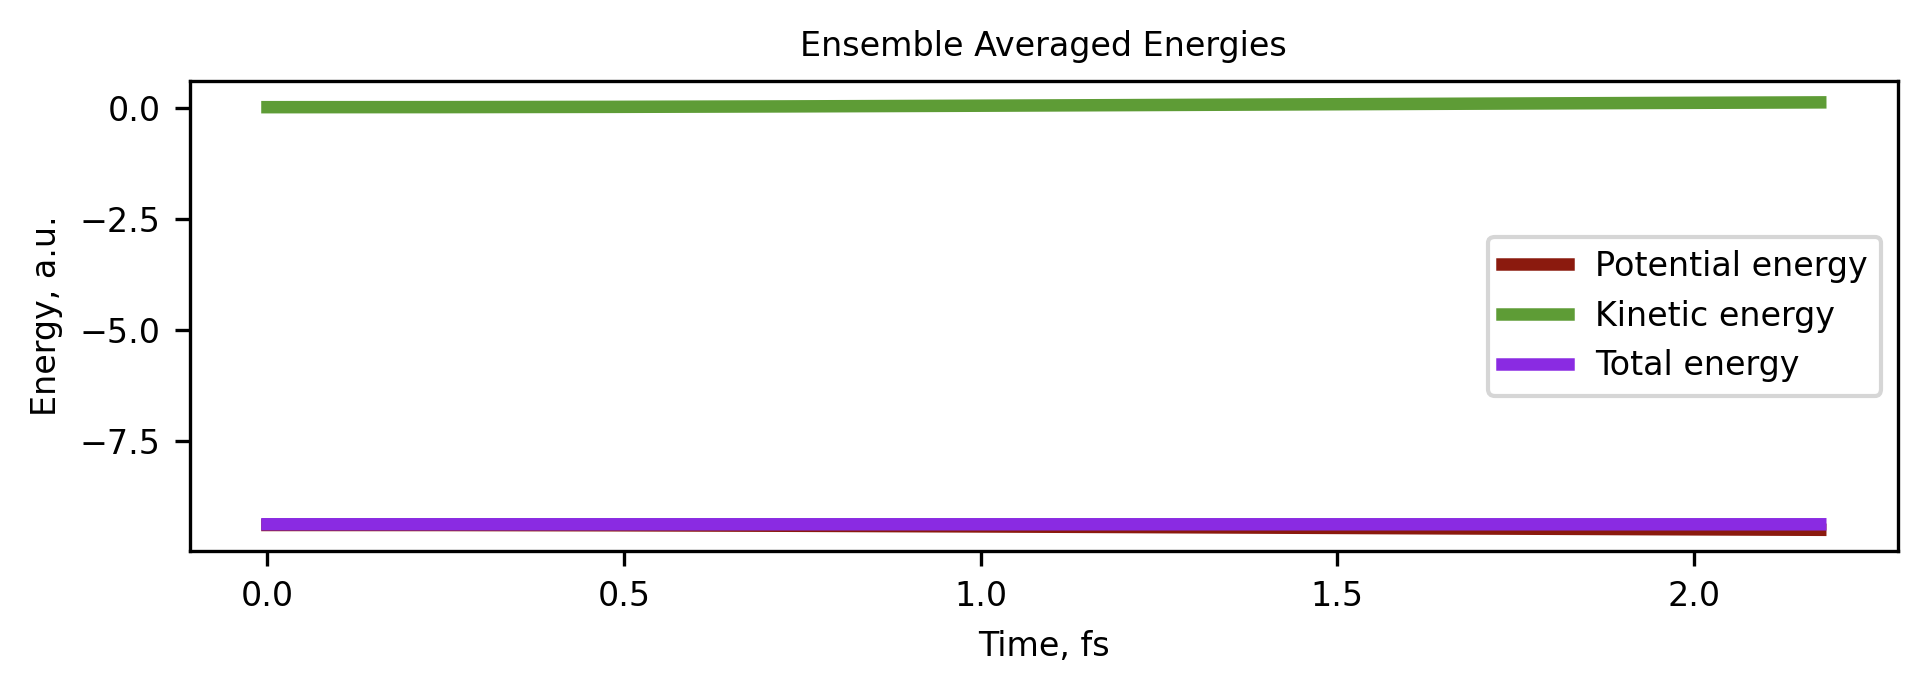

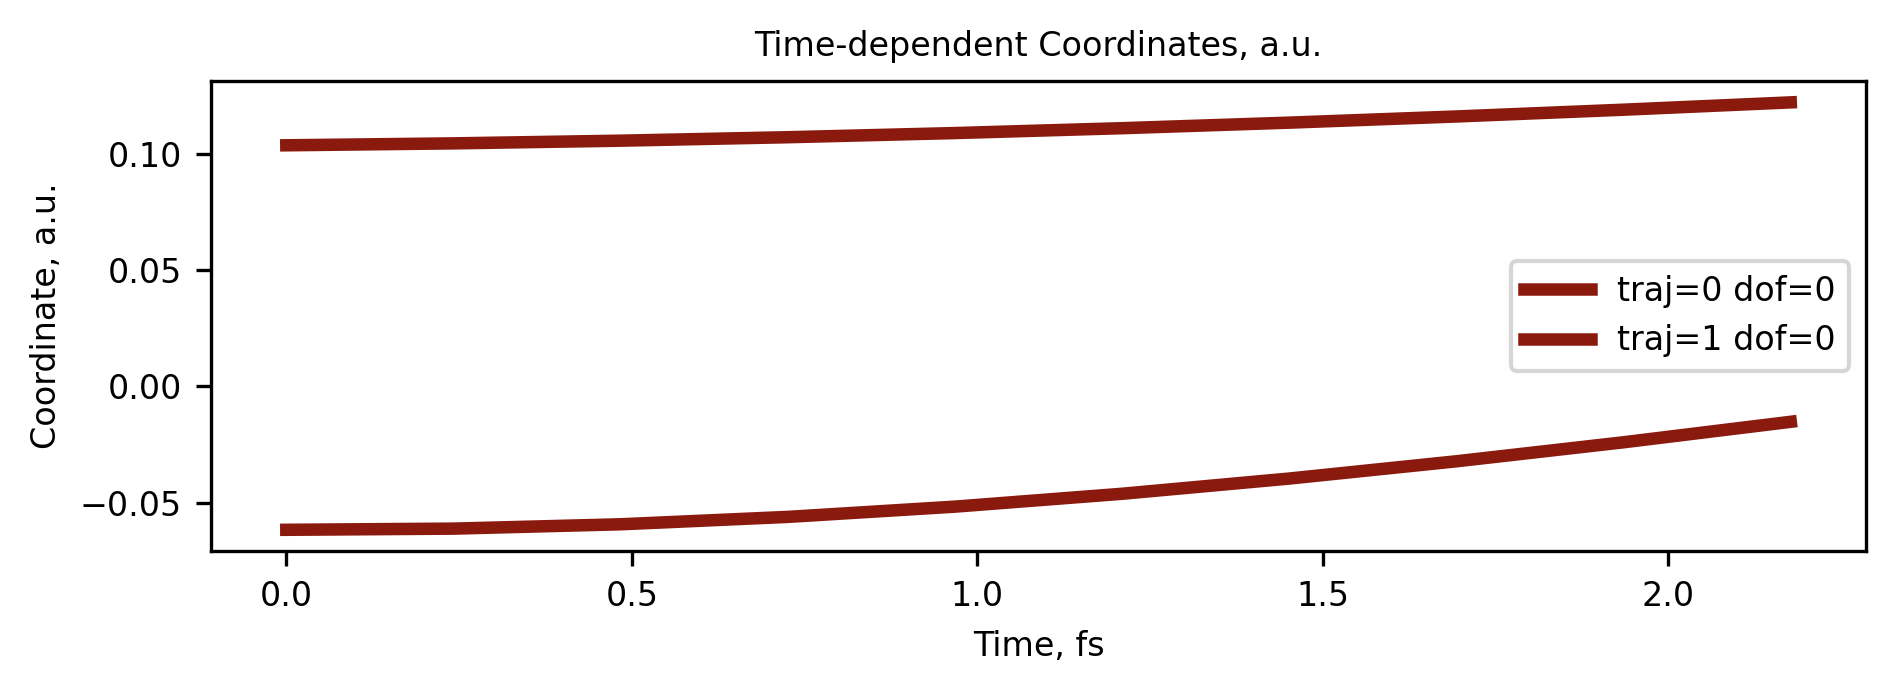

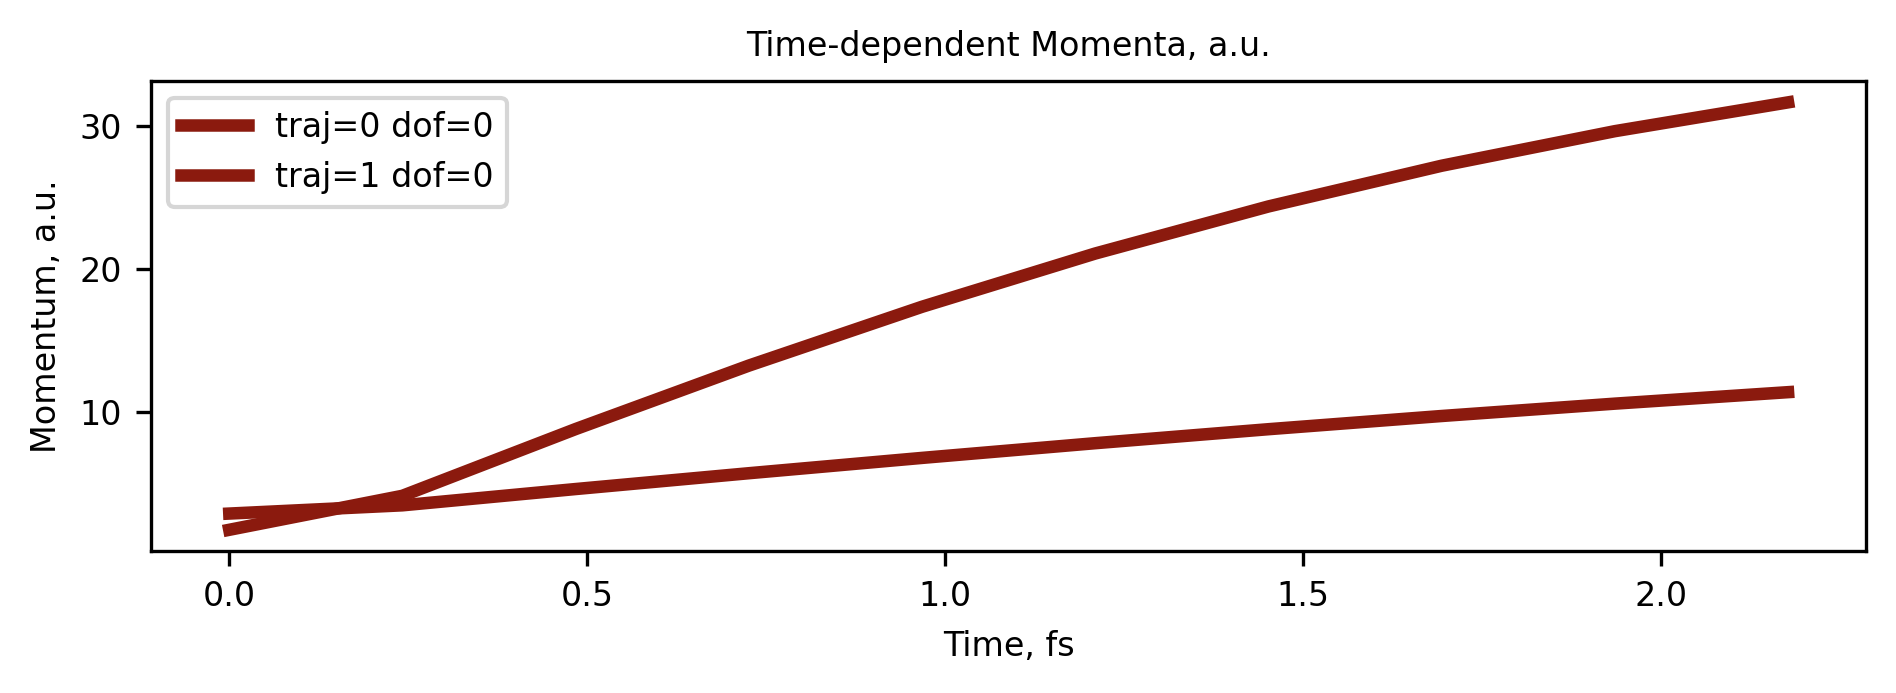

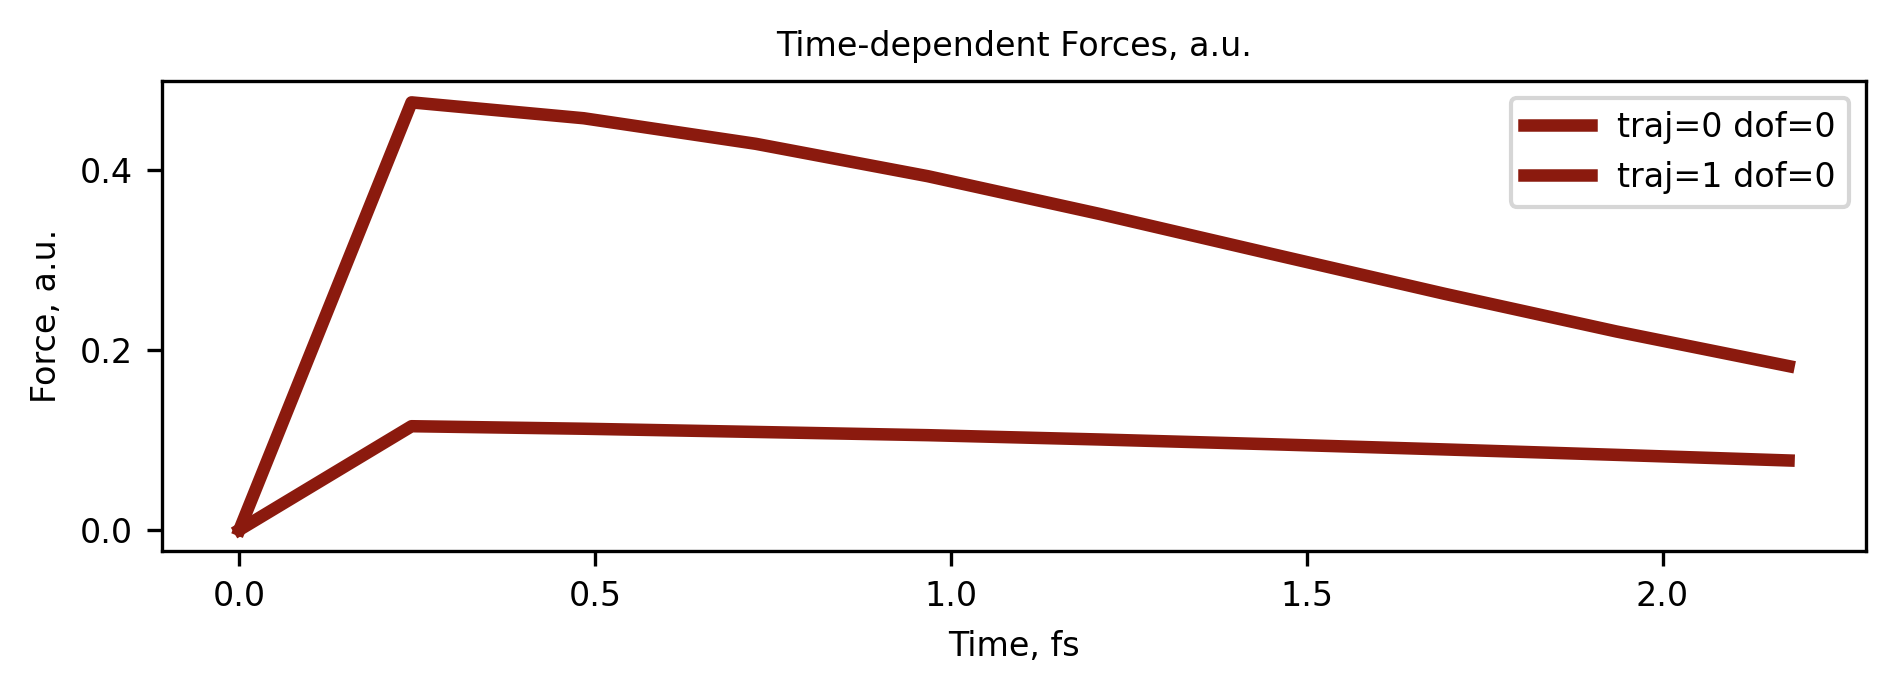

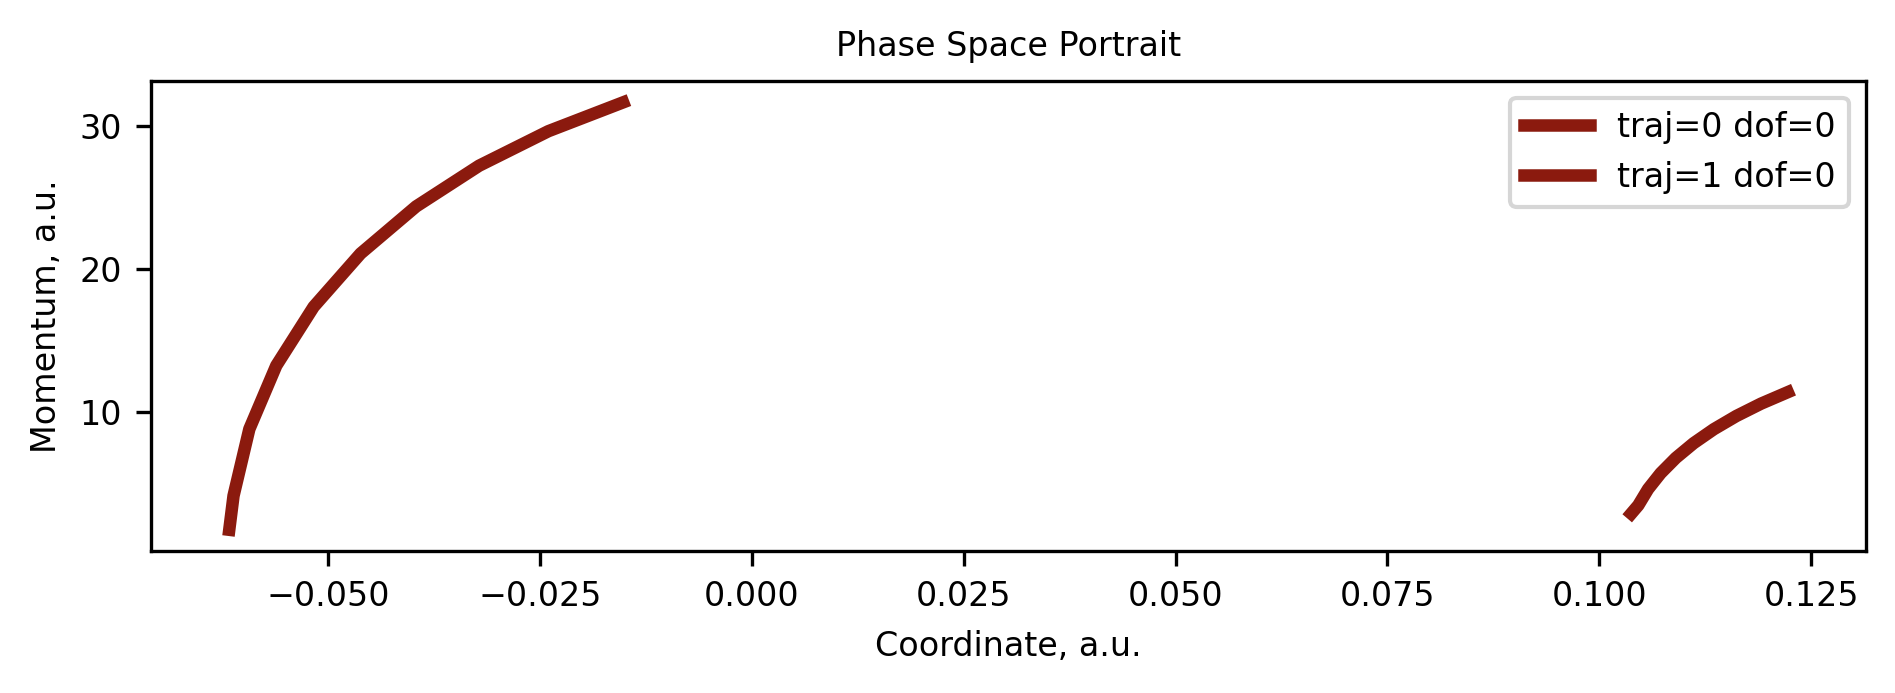

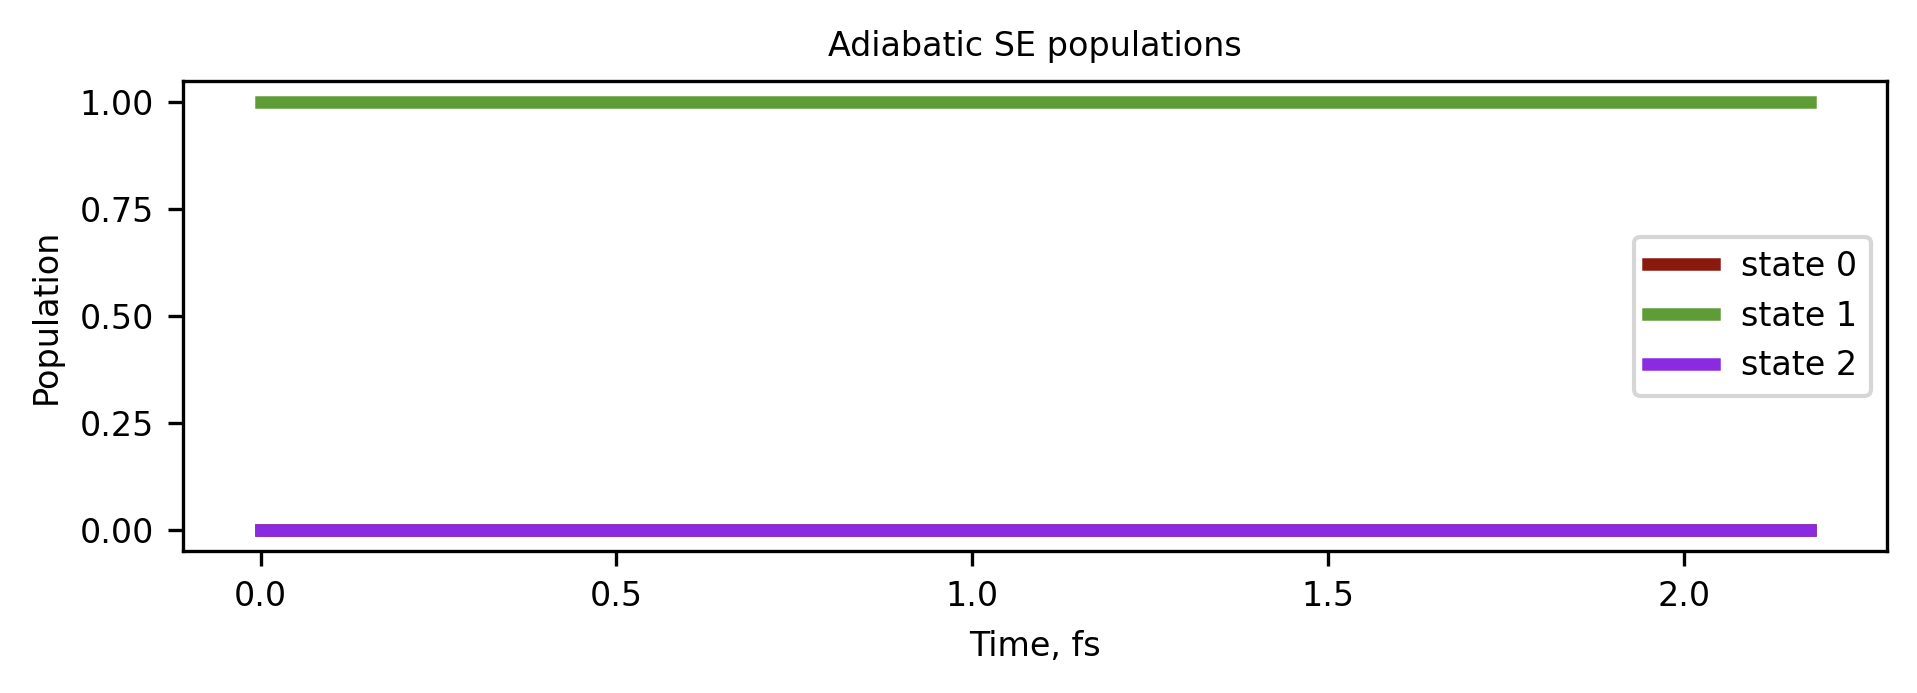

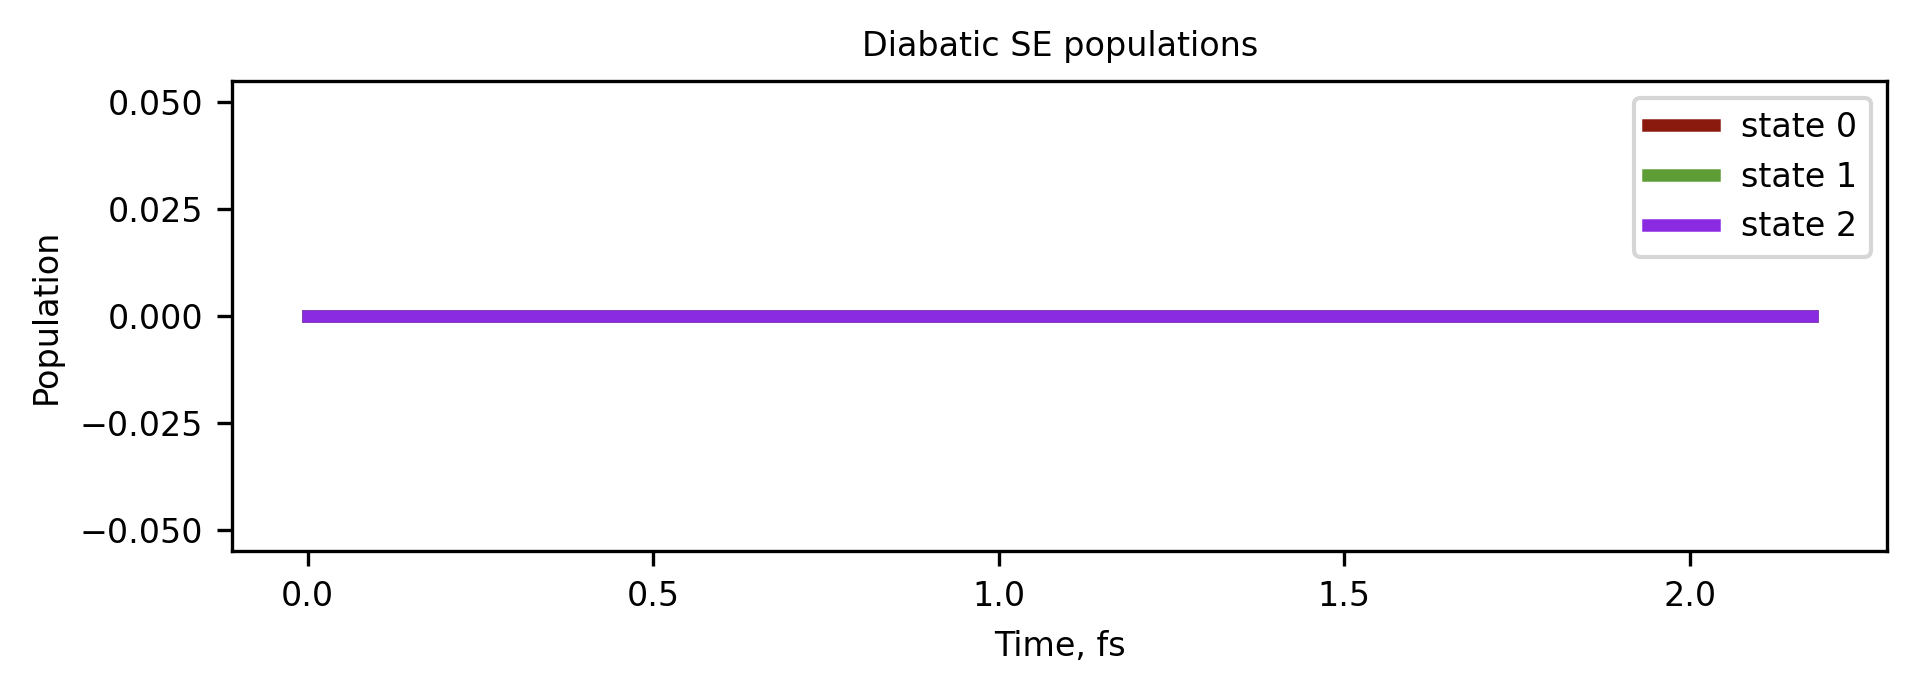

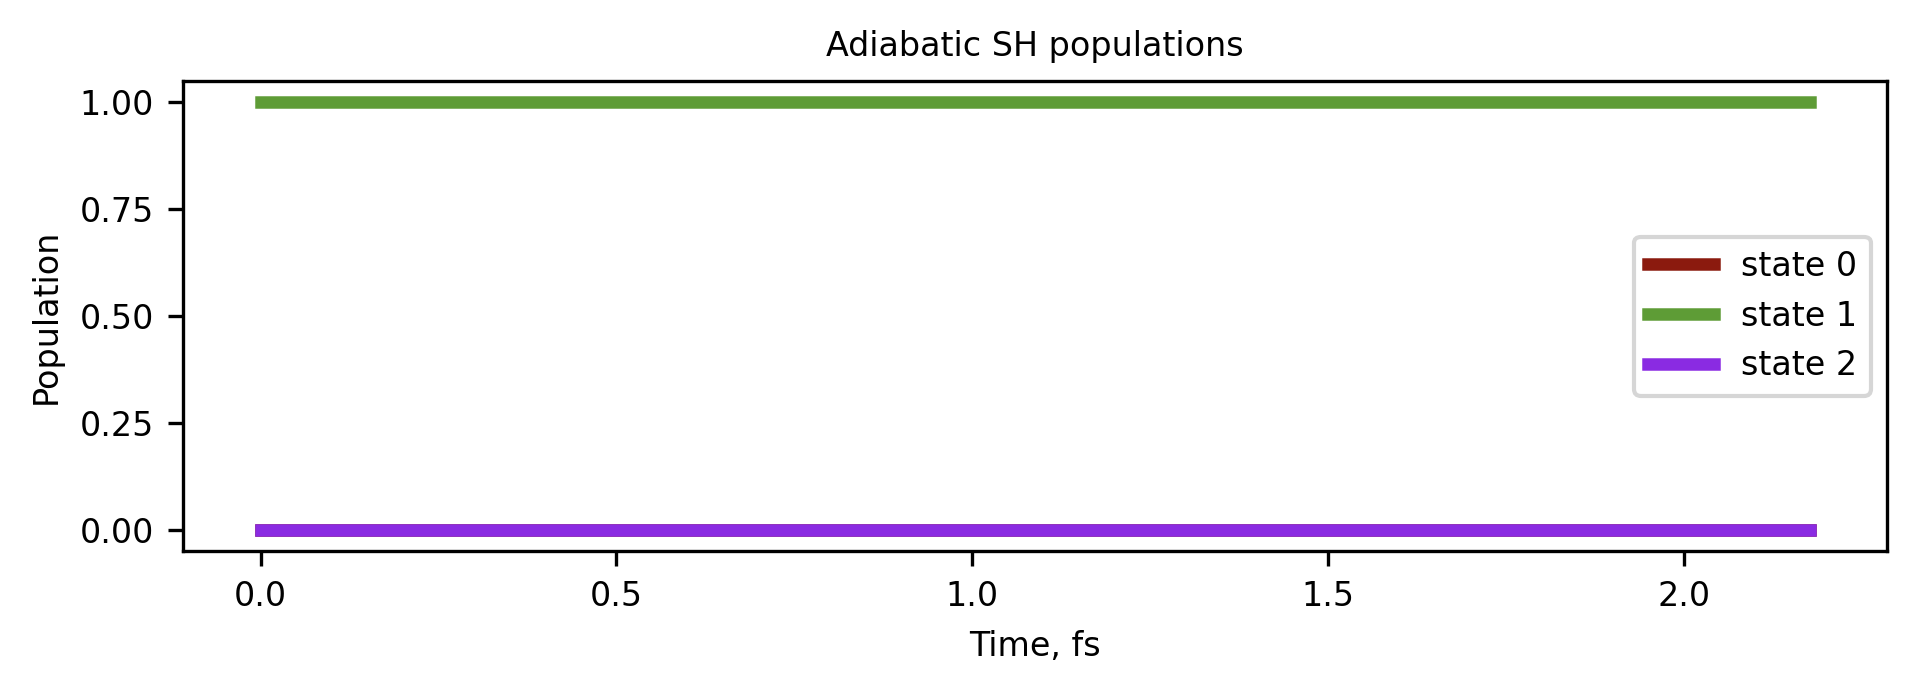

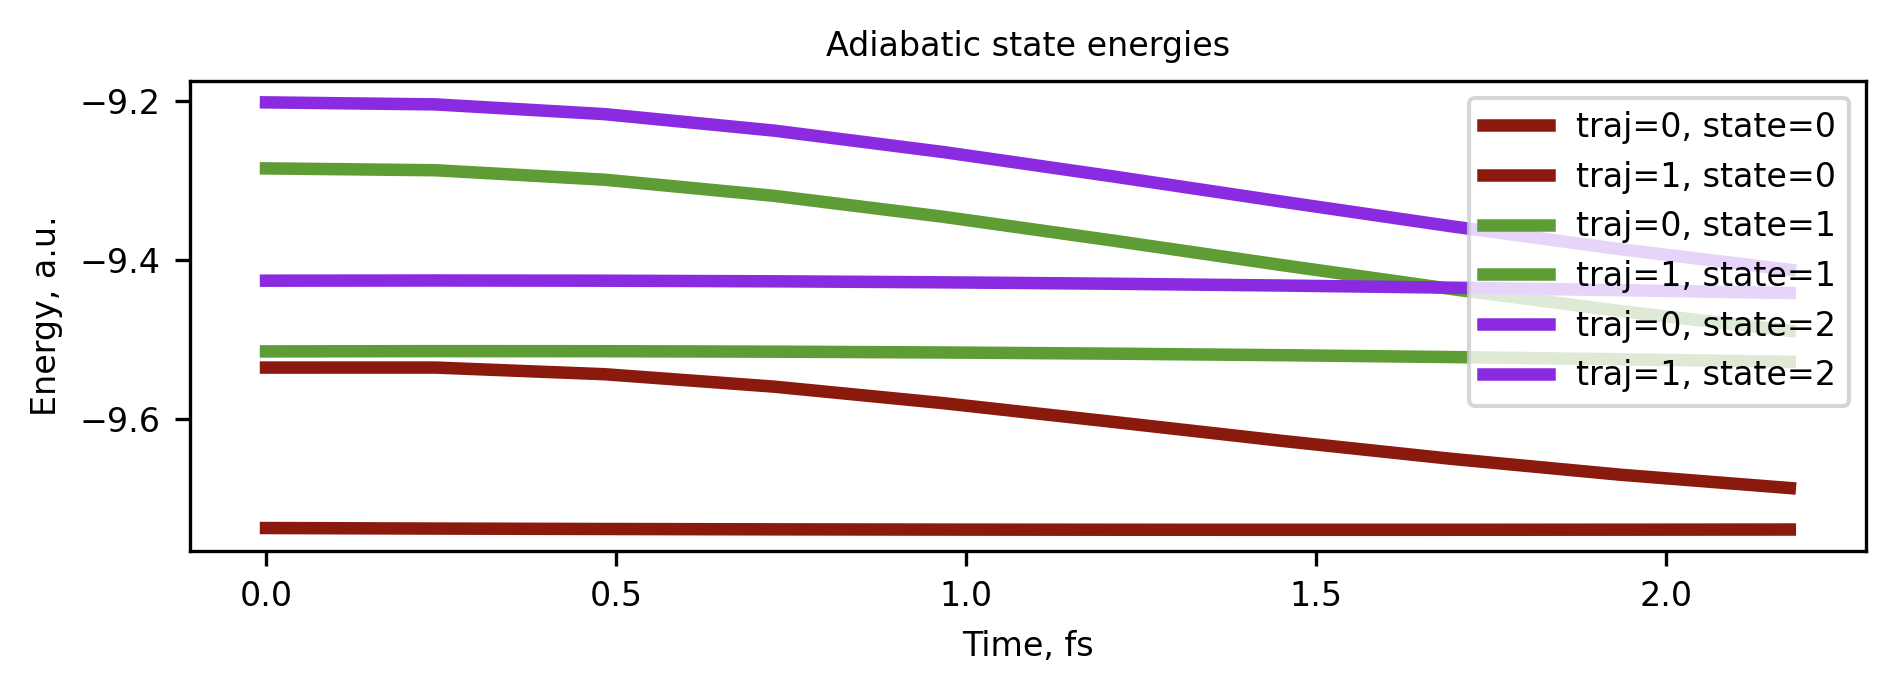

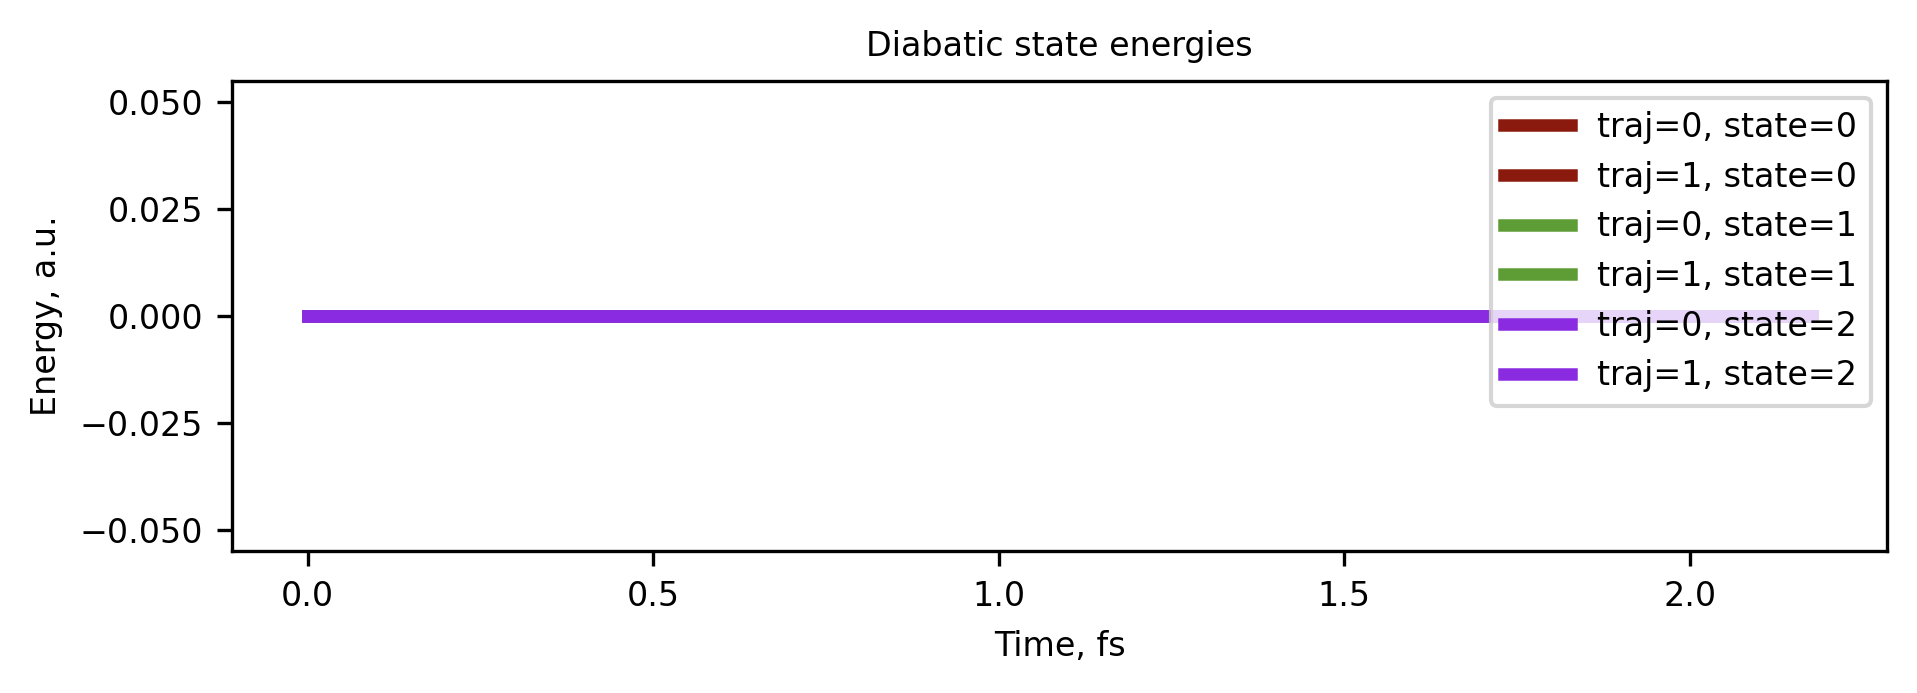

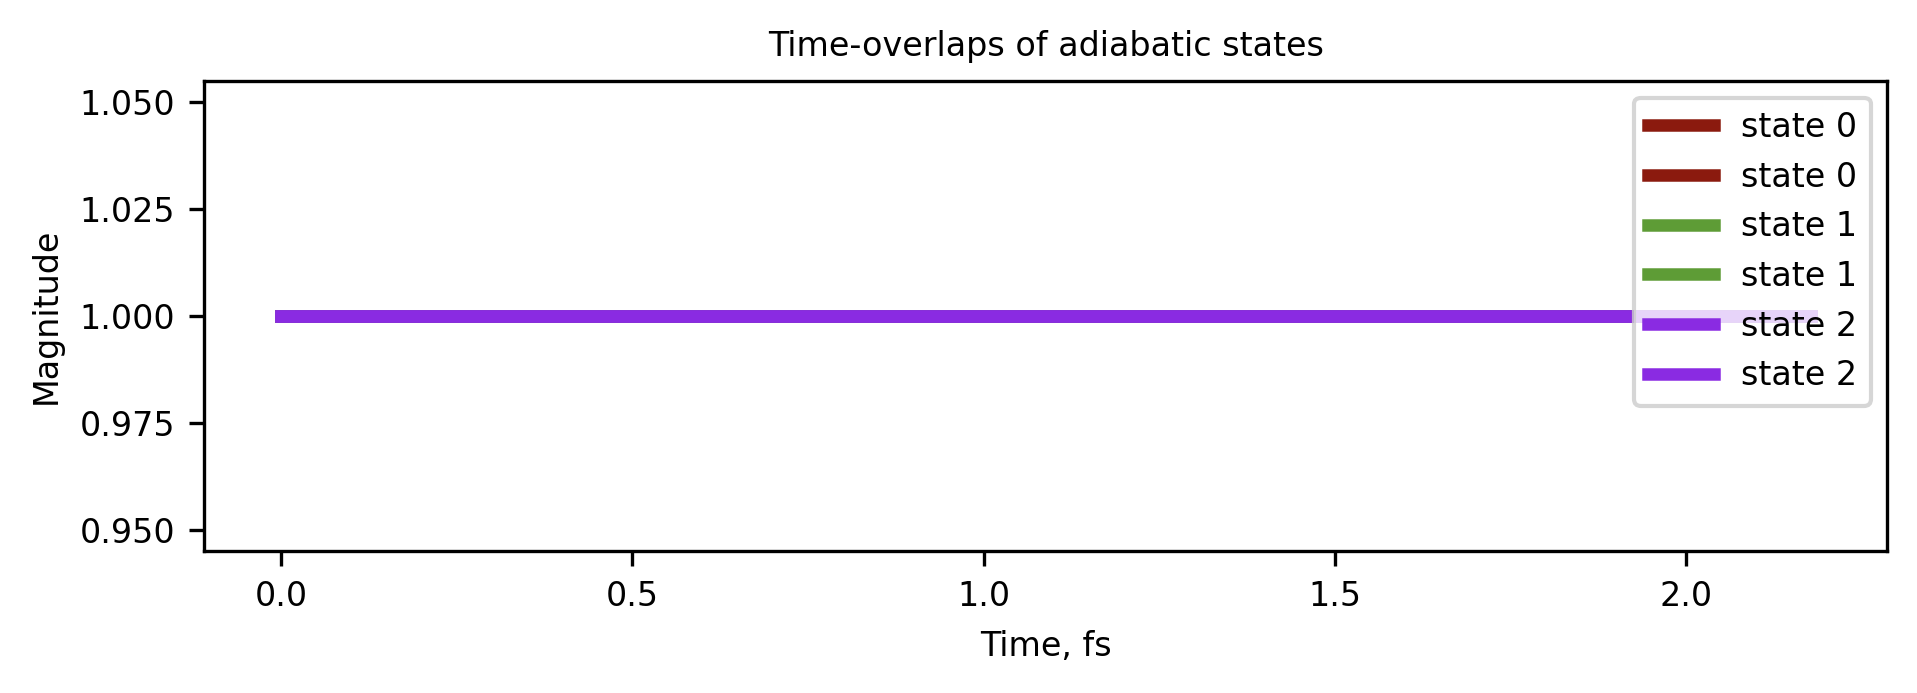

In [33]:
plot_params2 = { "prefix":"hfco-ex1", "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":[0, 1], "which_dofs":[0], "which_adi_states":[0,1,2], "which_dia_states":[0,1,2], 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
                                "se_pop_dia", "sh_pop_adi", "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham", 
                                "time_overlaps"
                               ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":1
              }

plot.plot_dynamics(plot_params2)

Now visualize the dynamics
<a name="hdf2xyz-ex3"></a>

In [35]:
#========= visualize the trajectories =============
labels = ["F", "C", "H", "O"]
prefix = dyn_params["prefix"]
filename = F"{prefix}/mem_data.hdf"
snaps = list(range(0, 10))
trajectories = [0, 1]
atoms = [0, 1, 2, 3] # all atoms
unit_conversion_factor = 1.0/units.Angst # convert to Angstrom

xyz = plot.hdf2xyz(labels, filename, snaps, trajectories, atoms, unit_conversion_factor)

view = py3Dmol.view(width=800,height=400)  
view.setBackgroundColor('0xeeeeee')                                     
view.zoomTo()                                                           
view.addModelsAsFrames(xyz, 'xyz')
view.setStyle({'sphere':{'colorscheme':'Jmol', }})                        
view.animate({'reps':0, 'loop':'forward', 'step':1})
view.show()  

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol